In [2]:
from itertools import product
import glob
import pickle

import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.feature import NaturalEarthFeature
import xarray as xr
from scipy.ndimage import gaussian_filter
import datetime

import xesmf as xe
import metpy.calc as mpcalc
from minisom import MiniSom,asymptotic_decay
from collections import Counter
# import optuna
#import sklearn
#from sklearn.metrics import mean_squared_error

In [3]:
slp_final=xr.open_dataset('slp_matched_final.nc')

In [4]:
slp_final

<xarray.Dataset> Size: 21MB
Dimensions:   (y: 56, x: 56, time: 849)
Coordinates:
    lon       (y) float64 448B ...
    lat       (x) float64 448B ...
  * time      (time) datetime64[ns] 7kB 1985-12-08 1985-12-10 ... 2017-03-31
Dimensions without coordinates: y, x
Data variables:
    variable  (time, y, x) float64 21MB ...

In [58]:
# Path to the directory containing the files
directory = '/expanse/nfs/cw3e/cdd105/winds_new/'

# Find all NetCDF files in the directory
files = sorted(glob.glob(directory + '*.nc'))

# Open multiple files and concatenate them along the time dimension
ds_winds_era52 = xr.open_mfdataset(files, combine='nested', concat_dim='time',engine='netcdf4')

# Print information about the dataset
print(ds_winds_era52)

<xarray.Dataset> Size: 48GB
Dimensions:    (time: 5800, latitude: 721, longitude: 1440)
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 46kB 1985-11-01 1985-11-02 ... 2017-04-30
Data variables:
    u          (time, latitude, longitude) float64 48GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-08 18:25:01 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...


In [76]:
mask_winds52=ds_winds_era52['time'].isin(wwrf_wind_u250['time'])

In [77]:
ds_winds_era52['time'][mask_winds52]

<xarray.DataArray 'time' (time: 849)> Size: 7kB
array(['1985-12-08T00:00:00.000000000', '1985-12-10T00:00:00.000000000',
       '1985-12-11T00:00:00.000000000', ..., '2017-03-28T00:00:00.000000000',
       '2017-03-29T00:00:00.000000000', '2017-03-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 7kB 1985-12-08 1985-12-10 ... 2017-03-31
Attributes:
    long_name:  time

In [63]:
u500_ungridded=xr.open_dataset('u500_winds_ungridded.nc')

In [53]:
rolling_mean_old=xr.open_dataset('rolling_era_means0228.nc')

In [51]:
# full_hts2=xr.open_dataset('hts144.nc')
# mask_hts=full_hts2['time'].isin(slp_final['time'])
# # era5 best grid import for ds_tmp
# era_best = xr.open_dataset('era_best.nc')

# # create ds_tmp to coarsen the west-wrf grid
# ds_tmp = xe.Regridder(full_hts2['variable'][mask_hts].isel(time=0).drop('time'), 
#                       rolling_mean_old['variable'].isel(time=0).drop('time'), 
#                       method="bilinear", reuse_weights=False)

In [60]:
wind_wwrf=xr.open_dataset('u250_xr.nc')

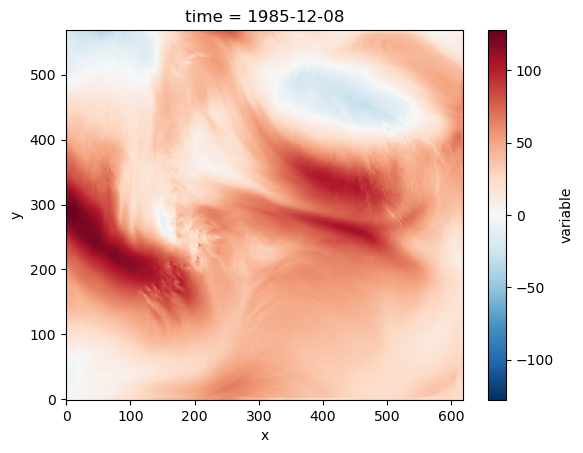

In [61]:
wind_wwrf['variable'].isel(time=0).plot()

In [66]:
full_hts2=xr.open_dataset('hts144.nc')
mask_hts=full_hts2['time'].isin(slp_final['time'])

In [67]:
ds_tmp_new = xe.Regridder(full_hts2['variable'][mask_hts].isel(time=0).drop('time'), 
                      wind_era5['u'].isel(time=0).drop('time'), 
                      method="bilinear", reuse_weights=False)

/scratch/geastho/job_32761892/ipykernel_2708486/1543357172.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ds_tmp_new = xe.Regridder(full_hts2['variable'][mask_hts].isel(time=0).drop('time'),
/scratch/geastho/job_32761892/ipykernel_2708486/1543357172.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  wind_era5['u'].isel(time=0).drop('time'),


In [23]:
wind_wwrf

<xarray.Dataset> Size: 1GB
Dimensions:   (time: 853, y: 569, x: 618)
Coordinates:
    lon       (y, x) float32 1MB ...
    lat       (y, x) float32 1MB ...
  * time      (time) datetime64[ns] 7kB 1985-12-08 1985-12-10 ... 2017-03-31
Dimensions without coordinates: y, x
Data variables:
    variable  (time, y, x) float32 1GB ...

In [17]:
#u500_mask=u500_winds['time'].isin(slp_final['time'])

In [15]:
#u500_winds['variable'][u500_mask]

In [69]:
wind_mask=wind_wwrf['time'].isin(slp_final['time'])

In [70]:
rewrf_lon=[]
rewrf_lat=[]
rewrf_xr=[]
for time in full_hts2['time'][mask_hts].values:
    
    #print(time)

    # regrid west wrf to era5 
    re_wwrf= ds_tmp_new(wind_wwrf['variable'][wind_mask].sel(time=time), keep_attrs=True, skipna=True)
    rewrf_xr.append(re_wwrf)

rewrf_xr=np.asarray(rewrf_xr)

In [71]:
rewrf_xr.shape

(849, 721, 1440)

In [72]:
wwrf_wind_u250=xr.Dataset({'u': (['time','latitude','longitude'],rewrf_xr)},
             coords={"longitude":(["longitude"],wind_era5['longitude'].data),
                     "latitude":(["latitude"],wind_era5['latitude'].data),
                    "time":(["time"],pd.to_datetime(full_hts2['time'][mask_hts].values))})

In [21]:
# wwrf_wind_u500=xr.Dataset({'u': (['time','latitude','longitude'],rewrf_xr)},
#              coords={"longitude":(["longitude"],wind_era5['longitude'].data),
#                      "latitude":(["latitude"],wind_era5['latitude'].data),
#                     "time":(["time"],pd.to_datetime(full_hts2['time'][mask_hts].values))})

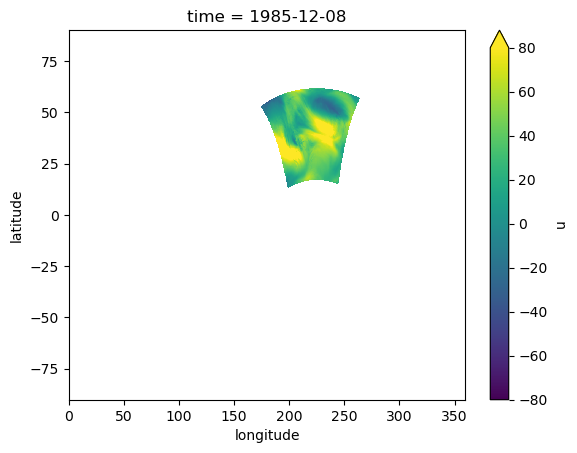

In [73]:
wwrf_wind_u250['u'].isel(time=0).plot(vmin=-80,vmax=80)

In [26]:
#wwrf_wind_u250.to_netcdf('wwrfwind_u250_gridded.nc')

In [27]:
#wwrf_wind_xr

In [74]:
wind_era5['u']

<xarray.DataArray 'u' (time: 849, latitude: 721, longitude: 1440)> Size: 7GB
[881465760 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 7kB 1985-12-08 1985-12-10 ... 2017-03-31
Attributes:
    units:          m s**-1
    long_name:      U component of wind
    standard_name:  eastward_wind

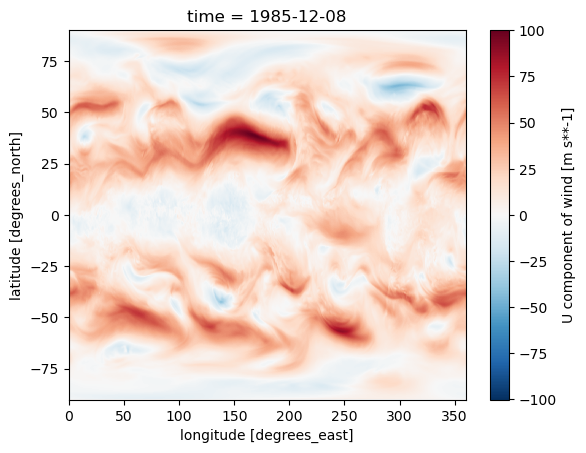

In [78]:
ds_winds_era52['u'][mask_winds52].isel(time=0).plot()

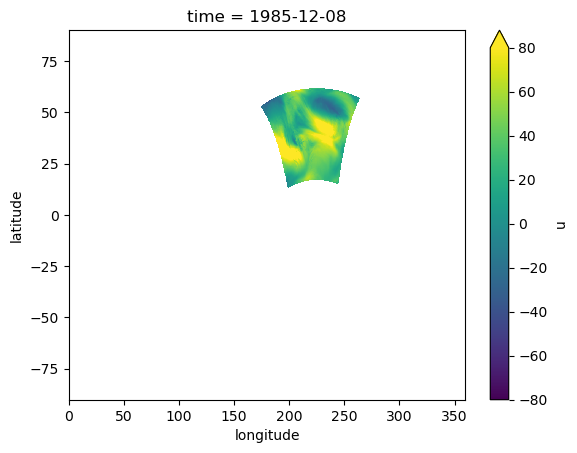

In [33]:
wwrf_wind_xr['u'].isel(time=0).plot(x='longitude',y='latitude',vmin=-80,vmax=80)

In [34]:
#wwrf_wind_u250.to_netcdf('wwrfwind_u250_gridded.nc')

In [83]:
wwrf_wind_u250_gridded=xr.open_dataset('wwrfwind_u250_gridded.nc')

In [84]:
wwrf_wind_ms=wwrf_wind_u250_gridded*0.514444

In [82]:
#np.isnan(wind_era5['u']).sum()

In [63]:
#wind_era5_filled_zero = wind_era5['u'].fillna(0)

In [84]:
#wwrf_wind_filled_0=wwrf_wind_ms['u']

In [81]:
#wind_era5_filled_zero.isel(time=0).plot(x='longitude',y='latitude')

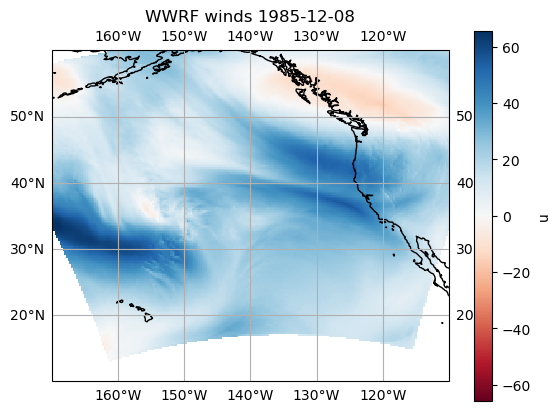

In [38]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the first time step of 'u' wind component
wwrf_wind_ms['u'].isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu')

# Set the extent (left, right, bottom, top) in degrees
ax.set_extent([-170, -110, 10, 60], crs=ccrs.PlateCarree())

# Add coastlines for reference
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.title('WWRF winds 1985-12-08')
plt.savefig('WWRF_winds.png',bbox_inches='tight',pad_inches = 0)
plt.show()

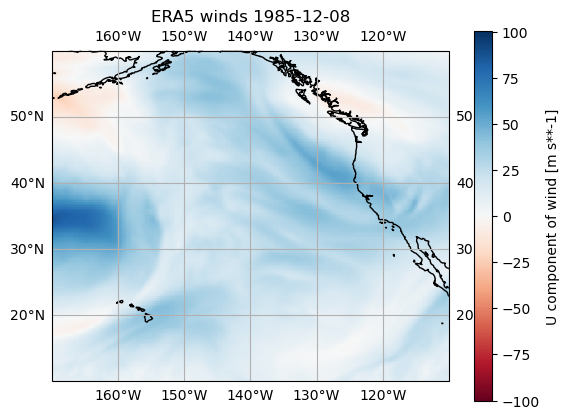

In [136]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the first time step of 'u' wind component
ds_winds_era52['u'][mask_winds52].isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu')

# Set the extent (left, right, bottom, top) in degrees
ax.set_extent([-170, -110, 10, 60], crs=ccrs.PlateCarree())

# Add coastlines for reference
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.title('ERA5 winds 1985-12-08')
plt.savefig('ERA5_winds.png',bbox_inches='tight',pad_inches = 0)
plt.show()

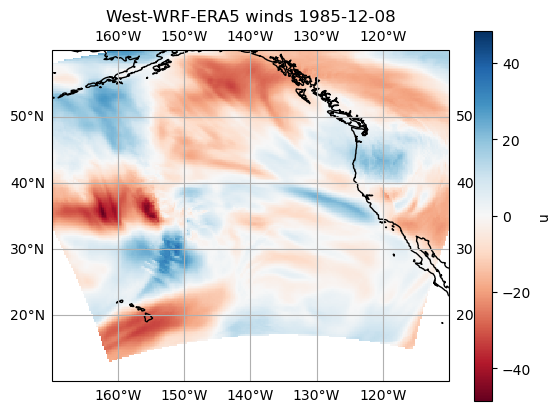

In [152]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the first time step of 'u' wind component
wind_diff.isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu')

# Set the extent (left, right, bottom, top) in degrees
ax.set_extent([-170, -110, 10, 60], crs=ccrs.PlateCarree())

# Add coastlines for reference
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.title('West-WRF-ERA5 winds 1985-12-08')
plt.savefig('wind_diff_winds.png',bbox_inches='tight',pad_inches = 0)
plt.show()

In [138]:
wind_diff=wwrf_wind_ms['u']-ds_winds_era52['u'][mask_winds52]

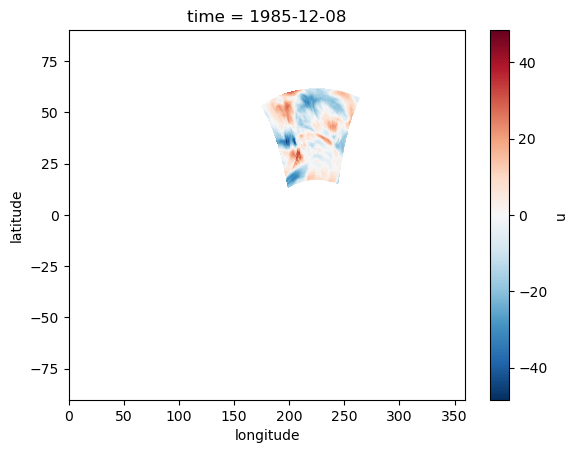

In [21]:
wind_diff['u'].isel(time=0).plot()

In [85]:
#wind_diff_0=wwrf_wind_filled_0-wind_era5_filled_zero

In [140]:
#wind_diff_0.isel(time=20).plot()

In [22]:
wind_diff['u'].max().values

array(84.08978212)

In [23]:
wind_diff['u'].min().values

array(-78.03851521)

In [85]:
wwrf_wind_ms.to_netcdf('wwrf_wind_ms.nc')

In [86]:
ds_winds_era52['u'][mask_winds52].to_netcdf('ds_winds_era250.nc')

In [144]:
wind_diff.to_netcdf('wind_diff_aug2_corrected.nc')

In [6]:
wind_diff=xr.open_dataset('wind_diff_aug2_corrected.nc')

In [7]:
smooth_fcst=xr.open_dataset('fcst_matched_0605.nc')
smooth_obs=xr.open_dataset('obs_matched_0605.nc')

In [8]:
def normalize_data(data):
    """
    Function for normalizing data prior to training using z-score
    """
    return (data - np.nanmean(data)) / np.nanstd(data)

In [15]:
mask=diff_forecast['time'].isin(slp_final['time'])

In [16]:
diff_forecast=xr.open_dataset('diff_matched_0605.nc')
diff_stack=diff_forecast['variable'][mask].stack(new=('y','x'))

In [ ]:
#dist_mask=centers_matched['fmt_date'].isin(pd.to_datetime(diff_stack['time']))

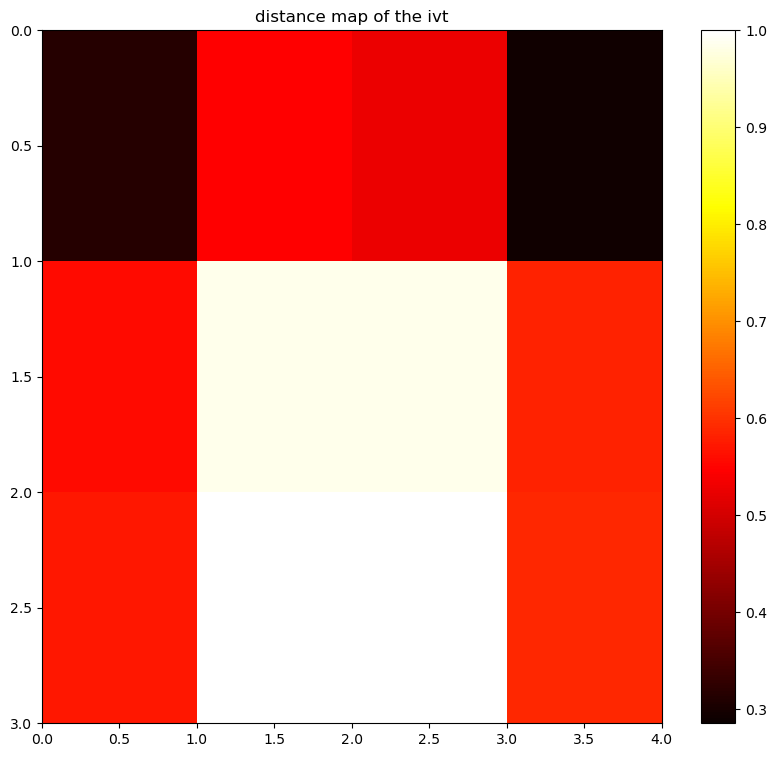

849
[0 1 2 3 3 2 3 1 3 1 2 1 3 3 3 2 3 0 0 1 3 3 0 1 0 3 3 2 1 3 3 2 3 2 3 3 1
 0 1 0 3 0 3 3 0 2 1 2 2 3 3 2 1 0 2 1 3 3 3 1 0 3 1 2 3 0 0 1 0 2 1 0 0 0
 0 1 3 3 2 0 3 2 3 2 2 2 1 0 3 0 2 3 0 0 0 0 0 0 1 2 1 1 1 1 3 0 1 1 2 3 0
 2 0 3 1 3 0 0 2 1 1 3 2 2 0 0 3 0 1 1 3 2 3 0 0 0 0 0 2 1 0 2 3 0 0 0 3 3
 1 2 3 0 3 2 2 3 0 1 0 0 0 0 1 1 1 2 0 0 2 0 0 1 0 1 0 0 0 1 1 3 0 2 0 3 3
 1 0 2 0 2 1 3 0 0 2 2 3 3 0 0 0 3 0 0 0 1 2 2 1 0 3 2 3 2 1 1 0 2 3 1 2 1
 2 0 2 2 0 0 3 0 3 2 2 2 1 3 0 3 1 2 0 0 3 1 0 2 3 3 3 3 1 0 0 0 0 0 0 1 0
 0 2 1 0 2 3 3 2 0 0 0 2 1 1 2 0 2 1 1 2 3 0 0 3 0 1 0 2 1 3 3 1 2 3 0 0 0
 2 0 2 1 1 1 3 0 3 0 3 1 1 1 0 3 3 3 3 3 3 2 0 2 3 3 3 3 3 3 2 1 1 0 2 3 2
 0 0 1 3 0 1 2 2 3 3 3 0 1 0 2 1 2 3 0 1 2 2 1 3 3 0 1 3 3 3 3 3 2 3 2 3 1
 1 1 0 0 2 0 0 2 1 3 1 0 1 2 3 1 2 0 0 2 1 0 1 0 2 1 1 1 1 3 2 2 3 0 3 2 2
 3 2 1 1 2 0 1 3 0 2 3 2 3 3 3 2 2 0 1 3 3 2 1 1 2 2 0 1 1 3 0 2 0 0 1 3 3
 2 3 0 0 3 3 1 2 0 1 0 0 3 0 3 0 3 0 0 2 3 0 0 1 3 0 1 2 3 1 1 0 3 1 0 0 2
 2 1 3 0 0 3 3 1 1 0 

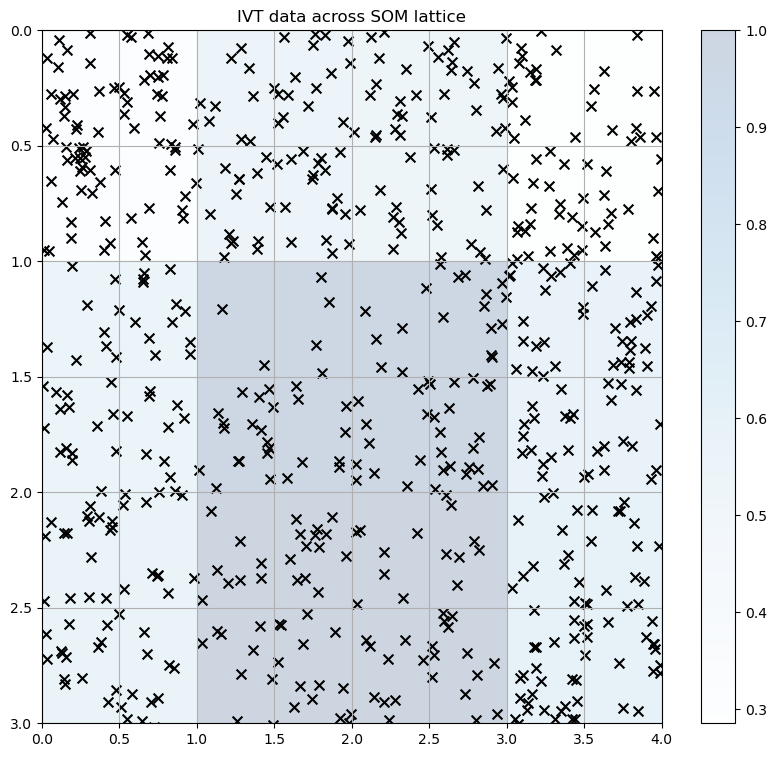

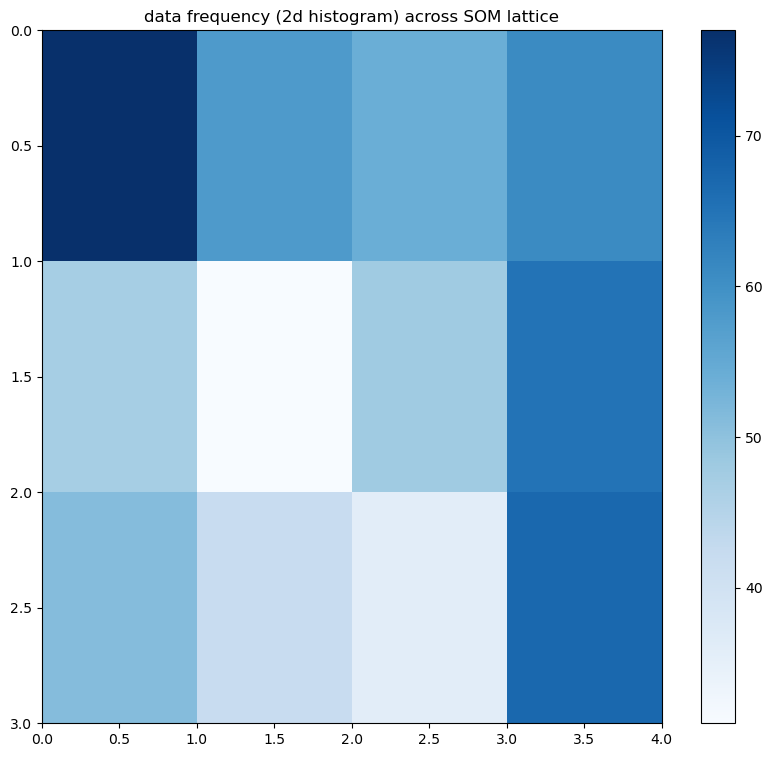

The rows and columns of the SOM lattice to use to grab SOM indexes:
[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]
[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]
Number of composite maps: 16


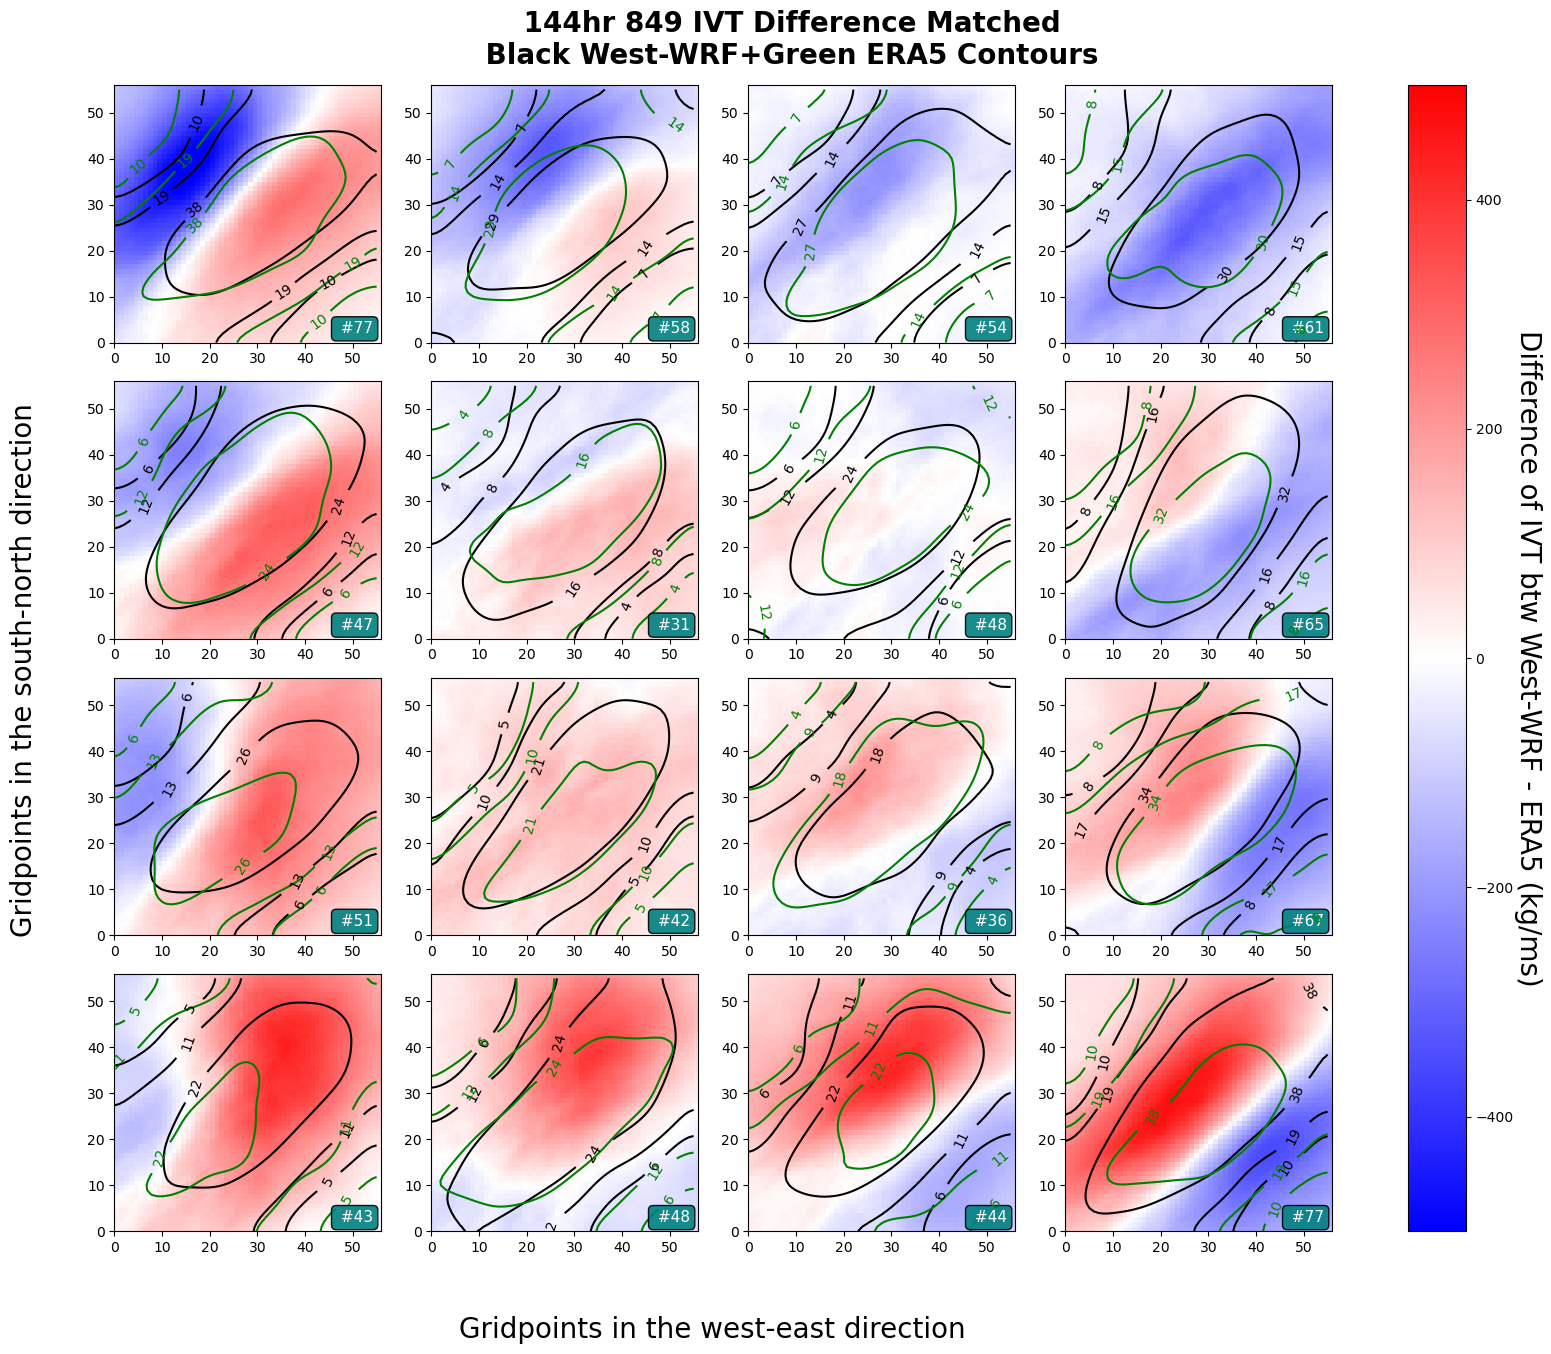

In [17]:
with open('som_matched_144_3.05_final.p', 'rb') as infile:
    newsom = pickle.load(infile)
# if som==newsom:
    
        
plt.figure(figsize=(10, 9))
cs = plt.pcolormesh(newsom.distance_map(), cmap='hot')
plt.title("distance map of the ivt", fontsize=12)
plt.colorbar(cs)
plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
plt.show()


# this may take a few minutes if lots of data! currently doing every 20th point so not bad

# grab the x and y coords across the lattice for the winner node for each data point

w_x, w_y = zip(*[newsom.winner(w) for w in normalize_data(diff_stack).values])
print(len(w_x))
w_x = np.array(w_x)
w_y = np.array(w_y)
print(w_x)
print(w_y)

# visualize where data falls in lattice (nearest winning neuron/node)

plt.figure(figsize=(10, 9))
plt.pcolormesh(newsom.distance_map(), cmap='Blues', alpha=.2)
plt.colorbar()

for num, c in enumerate(w_x[::1]):     # every 20th data point

    plt.scatter(w_y[num] + np.random.rand(1),   # add a random decimal to prevent overlapping of markers
                w_x[num] + np.random.rand(1),
                s=50, c='k', marker='x')

plt.title("IVT data across SOM lattice", fontsize=12)
plt.margins(x=0,y=0)
plt.grid()
plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
plt.show()



plt.figure(figsize=(10, 9))
frequencies = newsom.activation_response(normalize_data(diff_stack).values)
plt.pcolormesh(frequencies, cmap='Blues') 
plt.colorbar()
plt.title("data frequency (2d histogram) across SOM lattice", fontsize=12)
plt.ylim(3, 0)  # flip the y axis to be the same as composite map axes later
plt.show()

# grabbing indices from SOM
#all the cases for 2016-2017 500 mb heights are fairly similar 
# create an empty dictionary using the rows and columns of SOM
keys = [i for i in product(range(4),range(4))]
winmap = {key: [] for key in keys}

# grab the indices for the data within the SOM lattice
for i, x in enumerate(normalize_data(diff_stack).values):
    winmap[newsom.winner(x)].append(i)

print(f"The rows and columns of the SOM lattice to use to grab SOM indexes:\n{[i for i in list(winmap.keys())]}")
som_keys = list(winmap.keys())
print(som_keys)
print(f"Number of composite maps: {len(som_keys)}")


##plot som##
fig, geo_axs = plt.subplots(4, 4, figsize=(16,12))




# (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each 
for map_num in range(len(som_keys)):

    diff_data = diff_stack[np.array(winmap[som_keys[map_num]])].unstack().mean(dim="time",skipna=True)#.values
    fcst_data=smooth_fcst['__xarray_dataarray_variable__'][np.array(winmap[som_keys[map_num]])].sum(dim="time",skipna=True)
    obs_data=smooth_obs['__xarray_dataarray_variable__'][np.array(winmap[som_keys[map_num]])].sum(dim="time",skipna=True)
#     rmse_data=np.mean(dict_rmse[som_keys[map_num]])
    #dist_data=dist_new['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#             pv_data=pv[np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#         #         #diff_data=diff_fcsts[np.array(winmap[som_keys[map_num]])].unstack().sum(dim="time",skipna=True)
#             slp=slp_final['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#             ht500=ht_final['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#             pvplot=np.where(pv_data>.40,pv_data,np.nan)
#         #         pvplot=np.where(pv_data>.40,pv_data,np.nan)

#         ivt_era=era5ss_unmatch['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)
#         ivt_wwrf=regridwrf_unmatch['variable'][np.array(winmap[som_keys[map_num]])].mean(dim="time",skipna=True)

    #di_dates[som_keys[map_num][0],som_keys[map_num][1]]=diff_stack['time'][np.array(winmap[som_keys[map_num]])]

    projection = ccrs.PlateCarree()
    axs_class = (GeoAxes,
    dict(map_projection=projection))

#             g=[]
#             di_misses_v2={}
#             for m in miss_new['variable'].values:
#                 for key in di_dates:
#                                 #print(key)
#                     if m in di_dates[key]:

#                         if key not in di_misses_v2.keys():
#                                     di_misses_v2.update({key:m})
#                         else:
#                                 di_misses_v2[key] = di_misses_v2[key],m

#                         g.append(key)
#             e=[]
#             fa_dict={}
#             for f in fa_new['variable'].values:
#                 for key in di_dates:
#                     if f in di_dates[key]:
#                             if key not in fa_dict.keys():
#                                     fa_dict.update({key:f})
#                             else:
#                                     fa_dict[key] = fa_dict[key],f

#                             e.append(key)


#             new_dict=Counter(g)
#             new_dict_fa=Counter(e)





#             label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(slp,vmin=995, vmax=1020,cmap='rainbow')#cmap="Blues", 
    label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(diff_data,vmin=-500, vmax=500,cmap='bwr')
#             label=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].pcolormesh(pvplot,vmin=.45, vmax=.8,cmap='cool')


    n=(frequencies.flatten()[map_num])
#         htctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(ht500,colors="white") 

    #diffctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(diff_data,colors="black")  
    fcstctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(fcst_data,colors="black", levels=[n/8,n/4,n/2])  
    obsctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(obs_data,colors="green",levels=[n/8,n/4,n/2])#cmap="Blues", 
#             htctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(ht500, colors='black') #cmap="Blues", 
#             slpctr=geo_axs[som_keys[map_num][0],som_keys[map_num][1]].contour(slp, colors='black')
#     geo_axs[som_keys[map_num][0],som_keys[map_num][1]].set_title(f"Dist from MoE: {dist_data.values:.2f}\n Mean RMSE: {rmse_data:.3g}", fontsize=12)
# #             plt.clabel(slpctr,slpctr.levels[::2],fmt='%1.0f',colors='black')
#             plt.clabel(htctr,htctr.levels[::2],fmt='%1.0f',colors='black')

#                    
    plt.clabel(fcstctr,fmt='%1.0f',colors='black')
    plt.clabel(obsctr,fmt='%1.0f',colors='green')

#         # plot the figure containing all plots



    font = {
            'color':  'white',
            'weight': 'normal',
            'size': 11,
            }

    props = dict(boxstyle='round', facecolor='teal', alpha=.9)           
    geo_axs[som_keys[map_num][0],som_keys[map_num][1]].text(46.5,2,f" #{int(frequencies.flatten()[map_num])}",bbox=props,fontdict=font)
    plt.subplots_adjust(left=0.1,
            bottom=.1, 
            right=0.5, 
            top=.9, 
            wspace=0.8, 
            hspace=0.10)


plt.tight_layout()
fig = plt.gcf()
# twin_ax = fig.add_axes([-.05, 0.1, 0.02, 0.8])
# twin_ax.set_ylabel('Gridpoints in the north-south direction (1800 km)', fontsize=20, labelpad=10)
#twin_ax.yaxis.set_label_coords(1.1, 0.5)  # Adjust the position of the label
fig.text(-0.03, 0.5, 'Gridpoints in the south-north direction', fontsize=20, ha='center', va='center', rotation=90)


fig.text(.4,-.05,'Gridpoints in the west-east direction', fontsize=20, ha='center', va='center')

fig.suptitle(" 144hr 849 IVT Difference Matched \n Black West-WRF+Green ERA5 Contours ".format(sigma=newsom._sigma,lr =newsom._learning_rate), fontsize=20,y=1.05, x=0.45, fontweight='bold')

#Sigma:{sigma:.2f},LR:{lr:.4f}
#ax1=fig.colorbar(label, ax=fig.get_axes())
cbar=fig.colorbar(label, ax=fig.get_axes())

cbar.ax.set_ylabel('Difference of IVT btw West-WRF - ERA5 (kg/ms)', rotation=270, fontsize=20,labelpad=20
      )



plt.show()


In [18]:
wind_diff

<xarray.Dataset> Size: 7GB
Dimensions:    (longitude: 1440, latitude: 721, time: 849)
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 7kB 1985-12-08 1985-12-10 ... 2017-03-31
Data variables:
    u          (time, latitude, longitude) float64 7GB nan nan nan ... nan nan

In [25]:
winds1 = np.concatenate([
    wind_diff['u'][np.array(winmap[som_keys[0]])].values,
    wind_diff['u'][np.array(winmap[som_keys[1]])].values,
    wind_diff['u'][np.array(winmap[som_keys[4]])].values
])

winds2 = np.concatenate([
    wind_diff['u'][np.array(winmap[som_keys[2]])].values,
    wind_diff['u'][np.array(winmap[som_keys[3]])].values,
    wind_diff['u'][np.array(winmap[som_keys[7]])].values
])

winds3 = np.concatenate([
    wind_diff['u'][np.array(winmap[som_keys[8]])].values,
    wind_diff['u'][np.array(winmap[som_keys[12]])].values,
    wind_diff['u'][np.array(winmap[som_keys[13]])].values
])

winds4 = np.concatenate([
    wind_diff['u'][np.array(winmap[som_keys[11]])].values,
    wind_diff['u'][np.array(winmap[som_keys[14]])].values,
    wind_diff['u'][np.array(winmap[som_keys[15]])].values
])

In [26]:
winds1_mean=np.mean(winds1,axis=0)
winds2_mean=np.mean(winds2,axis=0)
winds3_mean=np.mean(winds3,axis=0)
winds4_mean=np.mean(winds4,axis=0)

In [27]:
wind_diff.min()

<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    u        float64 8B -78.04

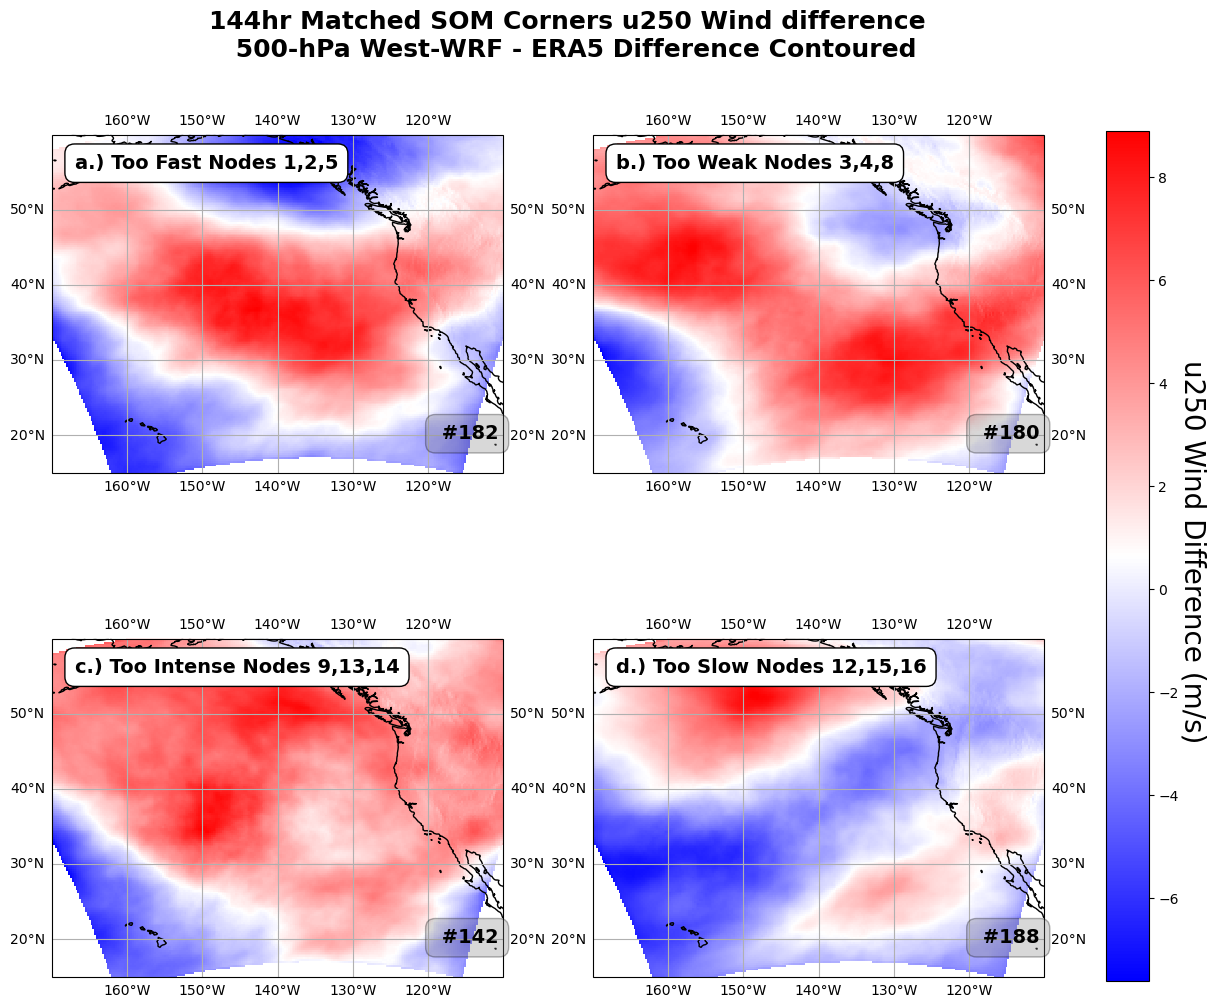

In [28]:
fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12), subplot_kw={'projection': ccrs.PlateCarree()})
label_list = ['a.) Too Fast Nodes 1,2,5', 'b.) Too Weak Nodes 3,4,8', 'c.) Too Intense Nodes 9,13,14', 'd.) Too Slow Nodes 12,15,16']
props2 = dict(boxstyle='round', facecolor='gray', alpha=.9)
label=geo_axs[0, 0].pcolormesh(wind_diff['longitude'],wind_diff['latitude'],winds1_mean, cmap='bwr')
geo_axs[0, 0].gridlines(draw_labels=True)
geo_axs[0, 0].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[0, 0].coastlines()
geo_axs[0, 0].text(0.05, 0.9, label_list[0], transform=geo_axs[0, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
# htctr=geo_axs[0, 0].contour(ht_diff_new['lon'],ht_diff_new['lat'],ht_diff_new['variable'][np.array(winmap[som_keys[0]])].mean(dim='time'), colors='black')
# plt.clabel(htctr,fmt='%1.0f',colors='black')
#geo_axs[0,0].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[0]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[0]])],color='mediumaquamarine')



geo_axs[0, 0].text(0.85, 0.1, f" #{int(len(winds1))}", transform=geo_axs[0, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))

label=geo_axs[0, 1].pcolormesh(wind_diff['longitude'],wind_diff['latitude'],winds2_mean, cmap='bwr')
geo_axs[0, 1].gridlines(draw_labels=True)
geo_axs[0, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[0, 1].coastlines()
geo_axs[0, 1].text(0.05, 0.9, label_list[1], transform=geo_axs[0, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[0, 1].text(0.85, 0.1, f" #{int(len(winds2))}", transform=geo_axs[0, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))
# htctr1=geo_axs[0, 1].contour(ht_diff_new['lon'],ht_diff_new['lat'],ht_diff_new['variable'][np.array(winmap[som_keys[3]])].mean(dim='time'), colors='black')
# plt.clabel(htctr1,fmt='%1.0f',colors='black')
#geo_axs[0,1].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[3]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[3]])],color='mediumaquamarine')

label=geo_axs[1, 0].pcolormesh(wind_diff['longitude'],wind_diff['latitude'],winds3_mean, cmap='bwr')
geo_axs[1, 0].gridlines(draw_labels=True)
geo_axs[1, 0].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[1, 0].coastlines()
geo_axs[1, 0].text(0.05, 0.9, label_list[2], transform=geo_axs[1, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[1, 0].text(0.85, 0.1, f" #{int(len(winds3))}", transform=geo_axs[1, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray',alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))
# htctr2=geo_axs[1, 0].contour(ht_diff_new['lon'],ht_diff_new['lat'],ht_diff_new['variable'][np.array(winmap[som_keys[12]])].mean(dim='time'), colors='black')
# plt.clabel(htctr2,fmt='%1.0f',colors='black')
#geo_axs[1,0].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[12]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[12]])],color='mediumaquamarine')

label=geo_axs[1, 1].pcolormesh(wind_diff['longitude'],wind_diff['latitude'],winds4_mean, cmap='bwr')

geo_axs[1, 1].gridlines(draw_labels=True)
geo_axs[1, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[1, 1].coastlines()
geo_axs[1, 1].text(0.05, 0.9, label_list[3], transform=geo_axs[1, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[1, 1].text(0.85, 0.1, f" #{int(len(winds4))}", transform=geo_axs[1, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))
# htctr3=geo_axs[1, 1].contour(ht_diff_new['lon'],ht_diff_new['lat'],ht_diff_new['variable'][np.array(winmap[som_keys[15]])].mean(dim='time'), colors='black')
# plt.clabel(htctr3,fmt='%1.0f',colors='black')
#geo_axs[1,1].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[15]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[15]])],color='mediumaquamarine')
# fig.suptitle(
#     "144hr Corner 258 (out of 849) 500-hPa Height Anomalies",
#     fontsize=18, y=.90, x=0.45, fontweight='bold'
# )
fig.suptitle(
    "144hr Matched SOM Corners u250 Wind difference \n 500-hPa West-WRF - ERA5 Difference Contoured",
    fontsize=18, y=.95, x=0.45, fontweight='bold'
)

cbar = fig.colorbar(label, ax=fig.get_axes(),shrink=0.92)
cbar.ax.set_ylabel('u250 Wind Difference (m/s) ', rotation=270, fontsize=20,labelpad=20
          )
#plt.savefig('144htanom_jan2024_corner.png',bbox_inches='tight',pad_inches = 0)
#plt.savefig('corrected_144Allnodeswind_ht_aug2024.png',bbox_inches='tight',pad_inches = 0)
plt.show()

In [29]:
ht_diff_new=xr.open_dataset('ht_diff_new.nc')

In [30]:
ht_diff_new

<xarray.Dataset> Size: 7GB
Dimensions:   (x: 1440, y: 721, time: 849)
Coordinates:
    lon       (x) float32 6kB ...
    lat       (y) float32 3kB ...
  * time      (time) datetime64[ns] 7kB 1985-12-08 1985-12-10 ... 2017-03-31
Dimensions without coordinates: x, y
Data variables:
    variable  (time, y, x) float64 7GB ...

In [31]:
ht_lines=xr.open_dataset('rewrf_dec2423.nc')

In [34]:
wind_diff

<xarray.Dataset> Size: 7GB
Dimensions:    (longitude: 1440, latitude: 721, time: 849)
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 7kB 1985-12-08 1985-12-10 ... 2017-03-31
Data variables:
    u          (time, latitude, longitude) float64 7GB nan nan nan ... nan nan

In [35]:
wind_diff['u'][np.array(winmap[som_keys[0]])]

<xarray.DataArray 'u' (time: 77, latitude: 721, longitude: 1440)> Size: 640MB
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 616B 1988-01-21 1988-12-07 ... 2017-02-20

In [36]:
wind_diff['u'][np.array(winmap[som_keys[3]])]

<xarray.DataArray 'u' (time: 61, latitude: 721, longitude: 1440)> Size: 507MB
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 488B 1986-02-16 1986-02-23 ... 2017-02-16

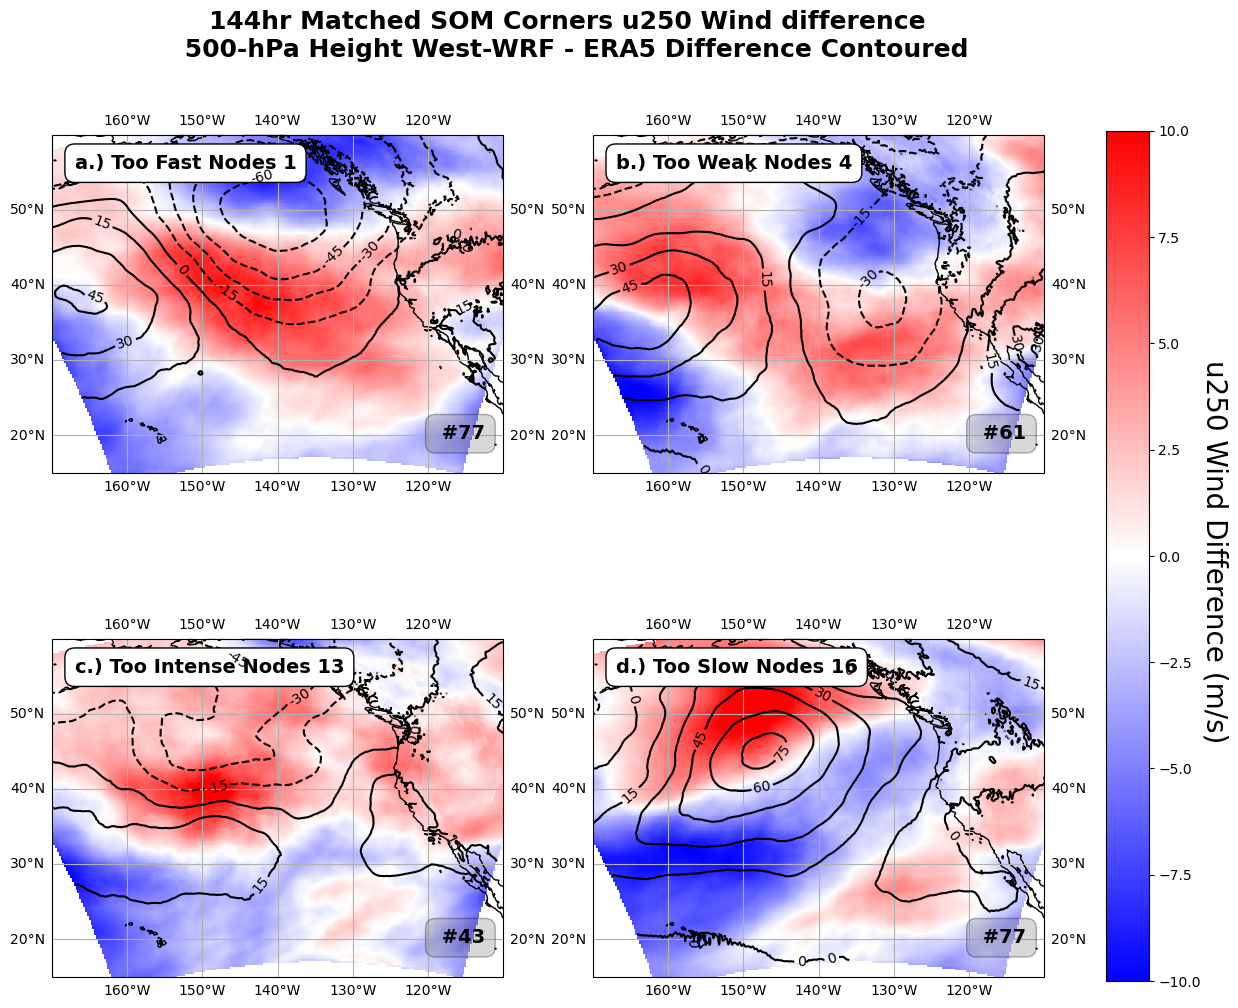

In [39]:
fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12), subplot_kw={'projection': ccrs.PlateCarree()})
label_list = ['a.) Too Fast Nodes 1', 'b.) Too Weak Nodes 4', 'c.) Too Intense Nodes 13', 'd.) Too Slow Nodes 16']
props2 = dict(boxstyle='round', facecolor='gray', alpha=.9)
label=geo_axs[0, 0].pcolormesh(wind_diff['longitude'],wind_diff['latitude'],wind_diff['u'][np.array(winmap[som_keys[0]])].mean(dim='time'), cmap='bwr',vmin=-10,vmax=10)
geo_axs[0, 0].gridlines(draw_labels=True)
geo_axs[0, 0].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[0, 0].coastlines()
geo_axs[0, 0].text(0.05, 0.9, label_list[0], transform=geo_axs[0, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
htctr=geo_axs[0, 0].contour(ht_diff_new['lon'],ht_diff_new['lat'],ht_diff_new['variable'][np.array(winmap[som_keys[0]])].mean(dim='time'), colors='black')
plt.clabel(htctr,fmt='%1.0f',colors='black')
#geo_axs[0,0].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[0]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[0]])],color='mediumaquamarine')



geo_axs[0, 0].text(0.85, 0.1, f" #{int(len(wind_diff['u'][np.array(winmap[som_keys[0]])]))}", transform=geo_axs[0, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))

label=geo_axs[0, 1].pcolormesh(wind_diff['longitude'],wind_diff['latitude'],wind_diff['u'][np.array(winmap[som_keys[3]])].mean(dim='time'), cmap='bwr',vmin=-10,vmax=10)
geo_axs[0, 1].gridlines(draw_labels=True)
geo_axs[0, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[0, 1].coastlines()
geo_axs[0, 1].text(0.05, 0.9, label_list[1], transform=geo_axs[0, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[0, 1].text(0.85, 0.1, f" #{int(len(wind_diff['u'][np.array(winmap[som_keys[3]])]))}", transform=geo_axs[0, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))
htctr1=geo_axs[0, 1].contour(ht_diff_new['lon'],ht_diff_new['lat'],ht_diff_new['variable'][np.array(winmap[som_keys[3]])].mean(dim='time'), colors='black')
plt.clabel(htctr1,fmt='%1.0f',colors='black')
#geo_axs[0,1].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[3]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[3]])],color='mediumaquamarine')

label=geo_axs[1, 0].pcolormesh(wind_diff['longitude'],wind_diff['latitude'],wind_diff['u'][np.array(winmap[som_keys[12]])].mean(dim='time'), cmap='bwr',vmin=-10,vmax=10)
geo_axs[1, 0].gridlines(draw_labels=True)
geo_axs[1, 0].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[1, 0].coastlines()
geo_axs[1, 0].text(0.05, 0.9, label_list[2], transform=geo_axs[1, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[1, 0].text(0.85, 0.1, f" #{int(len(wind_diff['u'][np.array(winmap[som_keys[12]])]))}", transform=geo_axs[1, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray',alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))
htctr2=geo_axs[1, 0].contour(ht_diff_new['lon'],ht_diff_new['lat'],ht_diff_new['variable'][np.array(winmap[som_keys[12]])].mean(dim='time'), colors='black')
plt.clabel(htctr2,fmt='%1.0f',colors='black')
#geo_axs[1,0].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[12]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[12]])],color='mediumaquamarine')

label=geo_axs[1, 1].pcolormesh(wind_diff['longitude'],wind_diff['latitude'],wind_diff['u'][np.array(winmap[som_keys[15]])].mean(dim='time'), cmap='bwr',vmin=-10,vmax=10)

geo_axs[1, 1].gridlines(draw_labels=True)
geo_axs[1, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[1, 1].coastlines()
geo_axs[1, 1].text(0.05, 0.9, label_list[3], transform=geo_axs[1, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[1, 1].text(0.85, 0.1, f" #{int(len(wind_diff['u'][np.array(winmap[som_keys[15]])]))}", transform=geo_axs[1, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))
htctr3=geo_axs[1, 1].contour(ht_diff_new['lon'],ht_diff_new['lat'],ht_diff_new['variable'][np.array(winmap[som_keys[15]])].mean(dim='time'), colors='black')
plt.clabel(htctr3,fmt='%1.0f',colors='black')
#geo_axs[1,1].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[15]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[15]])],color='mediumaquamarine')
# fig.suptitle(
#     "144hr Corner 258 (out of 849) 500-hPa Height Anomalies",
#     fontsize=18, y=.90, x=0.45, fontweight='bold'
# )
fig.suptitle(
    "144hr Matched SOM Corners u250 Wind difference \n 500-hPa Height West-WRF - ERA5 Difference Contoured",
    fontsize=18, y=.95, x=0.45, fontweight='bold'
)

cbar = fig.colorbar(label, ax=fig.get_axes(),shrink=0.92)
cbar.ax.set_ylabel('u250 Wind Difference (m/s) ', rotation=270, fontsize=20,labelpad=20
          )
#plt.savefig('144htanom_jan2024_corner.png',bbox_inches='tight',pad_inches = 0)
#plt.savefig('144Allnodeswind_ht_july22024.png',bbox_inches='tight',pad_inches = 0)
#plt.savefig('corrected_144CORNERnodeswind_ht_aug2_2024.png',bbox_inches='tight',pad_inches = 0)
plt.show()

In [40]:
# Path to the directory containing the files
directory = '/expanse/nfs/cw3e/cdd105/ht250/'

# Find all NetCDF files in the directory
files = sorted(glob.glob(directory + '*.nc'))

# Open multiple files and concatenate them along the time dimension
ds_hts_era52 = xr.open_mfdataset(files, combine='nested', concat_dim='time',engine='netcdf4')

# Print information about the dataset
print(ds_hts_era52)

<xarray.Dataset> Size: 13GB
Dimensions:    (time: 1561, latitude: 721, longitude: 1440)
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 12kB 1985-12-08 1985-12-10 ... 2017-03-31
Data variables:
    z          (time, latitude, longitude) float64 13GB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-08-02 18:11:50 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...


In [41]:
mask_hts250=ds_hts_era52['time'].isin(wind_diff['time'])

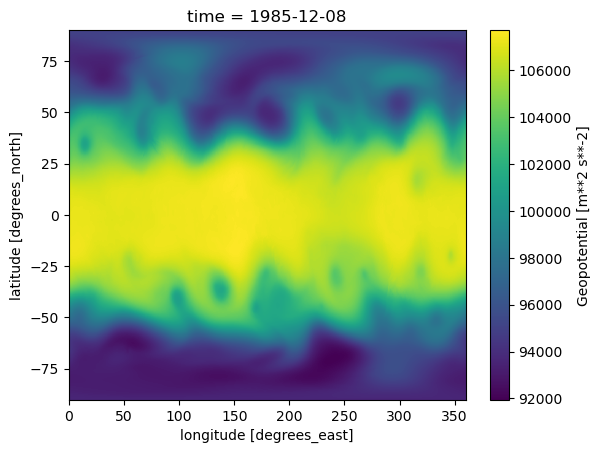

In [43]:
ds_hts_era52['z'][mask_hts250].isel(time=0).plot()

In [44]:
era_250ht=ds_hts_era52['z'][mask_hts250]/(9.80665)

In [45]:
era_250ht

<xarray.DataArray 'z' (time: 849, latitude: 721, longitude: 1440)> Size: 7GB
dask.array<truediv, shape=(849, 721, 1440), dtype=float64, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 7kB 1985-12-08 1985-12-10 ... 2017-03-31

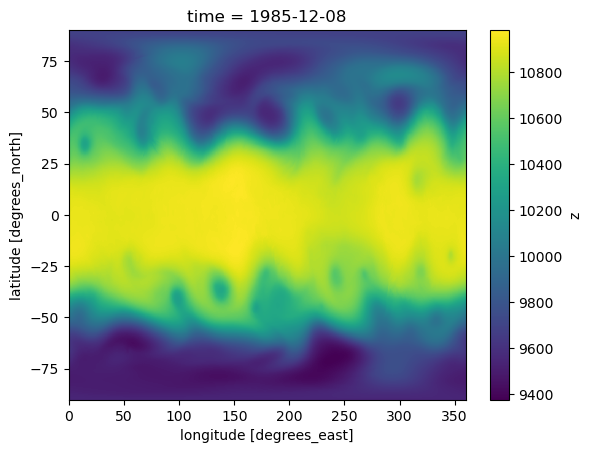

In [46]:
era_250ht.isel(time=0).plot()

In [87]:
wwrf_ht250=xr.open_dataset('dsgrid250_ungridded.nc')

In [91]:
ht250_mask=wwrf_ht250['time'].isin(slp_final['time'])

In [92]:
# rewrf_lon=[]
# rewrf_lat=[]
reht250_xr=[]
for time in full_hts2['time'][mask_hts].values:
    
    #print(time)

    # regrid west wrf to era5 
    re_ht= ds_tmp_new(wwrf_ht250['variable'][ht250_mask].sel(time=time), keep_attrs=True, skipna=True)
    reht250_xr.append(re_ht)

reht250_xr=np.asarray(reht250_xr)

In [93]:
wwrf_ht250_xr=xr.Dataset({'u': (['time','latitude','longitude'],reht250_xr)},
             coords={"longitude":(["longitude"],wind_era5['longitude'].data),
                     "latitude":(["latitude"],wind_era5['latitude'].data),
                    "time":(["time"],pd.to_datetime(full_hts2['time'][mask_hts].values))})

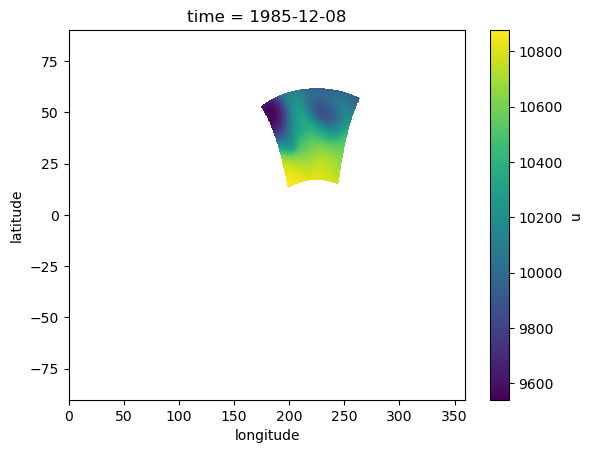

In [96]:
wwrf_ht250_xr['u'].isel(time=0).plot()

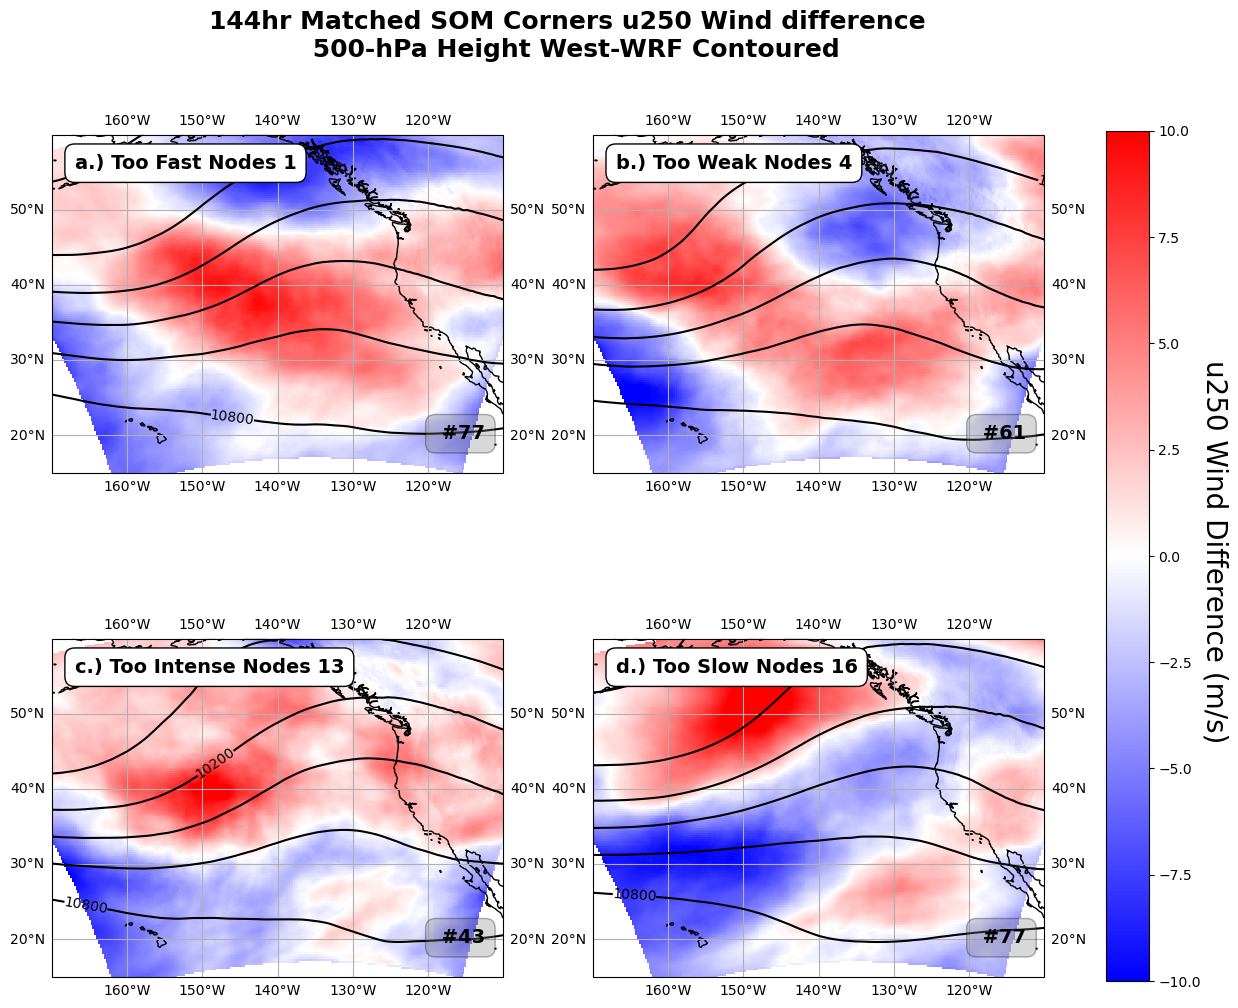

In [50]:
fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12), subplot_kw={'projection': ccrs.PlateCarree()})
Ht_levels=[5280,5340,5400,5460,5520,5580,5640,5700,5760,5820,5880,6040]
laebel_list = ['a.) Too Fast Nodes 1', 'b.) Too Weak Nodes 4', 'c.) Too Intense Nodes 13', 'd.) Too Slow Nodes 16']
props2 = dict(boxstyle='round', facecolor='gray', alpha=.9)
label=geo_axs[0, 0].pcolormesh(wind_diff['longitude'],wind_diff['latitude'],wind_diff['u'][np.array(winmap[som_keys[0]])].mean(dim='time'), cmap='bwr',vmin=-10,vmax=10)
geo_axs[0, 0].gridlines(draw_labels=True)
geo_axs[0, 0].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[0, 0].coastlines()
geo_axs[0, 0].text(0.05, 0.9, label_list[0], transform=geo_axs[0, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
htctr=geo_axs[0, 0].contour(era_250ht['longitude'],era_250ht['latitude'],era_250ht[np.array(winmap[som_keys[0]])].mean(dim='time'), colors='black')
plt.clabel(htctr,fmt='%1.0f',colors='black')
#geo_axs[0,0].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[0]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[0]])],color='mediumaquamarine')



geo_axs[0, 0].text(0.85, 0.1, f" #{int(len(wind_diff['u'][np.array(winmap[som_keys[0]])]))}", transform=geo_axs[0, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))

label=geo_axs[0, 1].pcolormesh(wind_diff['longitude'],wind_diff['latitude'],wind_diff['u'][np.array(winmap[som_keys[3]])].mean(dim='time'), cmap='bwr',vmin=-10,vmax=10)
geo_axs[0, 1].gridlines(draw_labels=True)
geo_axs[0, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[0, 1].coastlines()
geo_axs[0, 1].text(0.05, 0.9, label_list[1], transform=geo_axs[0, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[0, 1].text(0.85, 0.1, f" #{int(len(wind_diff['u'][np.array(winmap[som_keys[3]])]))}", transform=geo_axs[0, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))
htctr1=geo_axs[0, 1].contour(era_250ht['longitude'],era_250ht['latitude'],era_250ht[np.array(winmap[som_keys[3]])].mean(dim='time'), colors='black')
plt.clabel(htctr1,fmt='%1.0f',colors='black')
#geo_axs[0,1].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[3]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[3]])],color='mediumaquamarine')

label=geo_axs[1, 0].pcolormesh(wind_diff['longitude'],wind_diff['latitude'],wind_diff['u'][np.array(winmap[som_keys[12]])].mean(dim='time'), cmap='bwr',vmin=-10,vmax=10)
geo_axs[1, 0].gridlines(draw_labels=True)
geo_axs[1, 0].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[1, 0].coastlines()
geo_axs[1, 0].text(0.05, 0.9, label_list[2], transform=geo_axs[1, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[1, 0].text(0.85, 0.1, f" #{int(len(wind_diff['u'][np.array(winmap[som_keys[12]])]))}", transform=geo_axs[1, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray',alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))
htctr2=geo_axs[1, 0].contour(era_250ht['longitude'],era_250ht['latitude'],era_250ht[np.array(winmap[som_keys[12]])].mean(dim='time'), colors='black')
plt.clabel(htctr2,fmt='%1.0f',colors='black')
#geo_axs[1,0].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[12]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[12]])],color='mediumaquamarine')

label=geo_axs[1, 1].pcolormesh(wind_diff['longitude'],wind_diff['latitude'],wind_diff['u'][np.array(winmap[som_keys[15]])].mean(dim='time'), cmap='bwr',vmin=-10,vmax=10)

geo_axs[1, 1].gridlines(draw_labels=True)
geo_axs[1, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[1, 1].coastlines()
geo_axs[1, 1].text(0.05, 0.9, label_list[3], transform=geo_axs[1, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[1, 1].text(0.85, 0.1, f" #{int(len(wind_diff['u'][np.array(winmap[som_keys[15]])]))}", transform=geo_axs[1, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))
htctr3=geo_axs[1, 1].contour(era_250ht['longitude'],era_250ht['latitude'],era_250ht[np.array(winmap[som_keys[15]])].mean(dim='time'), colors='black')
plt.clabel(htctr3,fmt='%1.0f',colors='black')
#geo_axs[1,1].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[15]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[15]])],color='mediumaquamarine')
# fig.suptitle(
#     "144hr Corner 258 (out of 849) 500-hPa Height Anomalies",
#     fontsize=18, y=.90, x=0.45, fontweight='bold'
# )
fig.suptitle(
    "144hr Matched SOM Corners u250 Wind difference \n 500-hPa Height West-WRF Contoured",
    fontsize=18, y=.95, x=0.45, fontweight='bold'
)

cbar = fig.colorbar(label, ax=fig.get_axes(),shrink=0.92)
cbar.ax.set_ylabel('u250 Wind Difference (m/s) ', rotation=270, fontsize=20,labelpad=20
          )
#plt.savefig('144htanom_jan2024_corner.png',bbox_inches='tight',pad_inches = 0)
#plt.savefig('144Allnodeswind_ht_july22024.png',bbox_inches='tight',pad_inches = 0)
#plt.savefig('corrected500ht_144CORNERnodeswind_aug2_2024.png',bbox_inches='tight',pad_inches = 0)
plt.show()

In [140]:
9900-60


9840

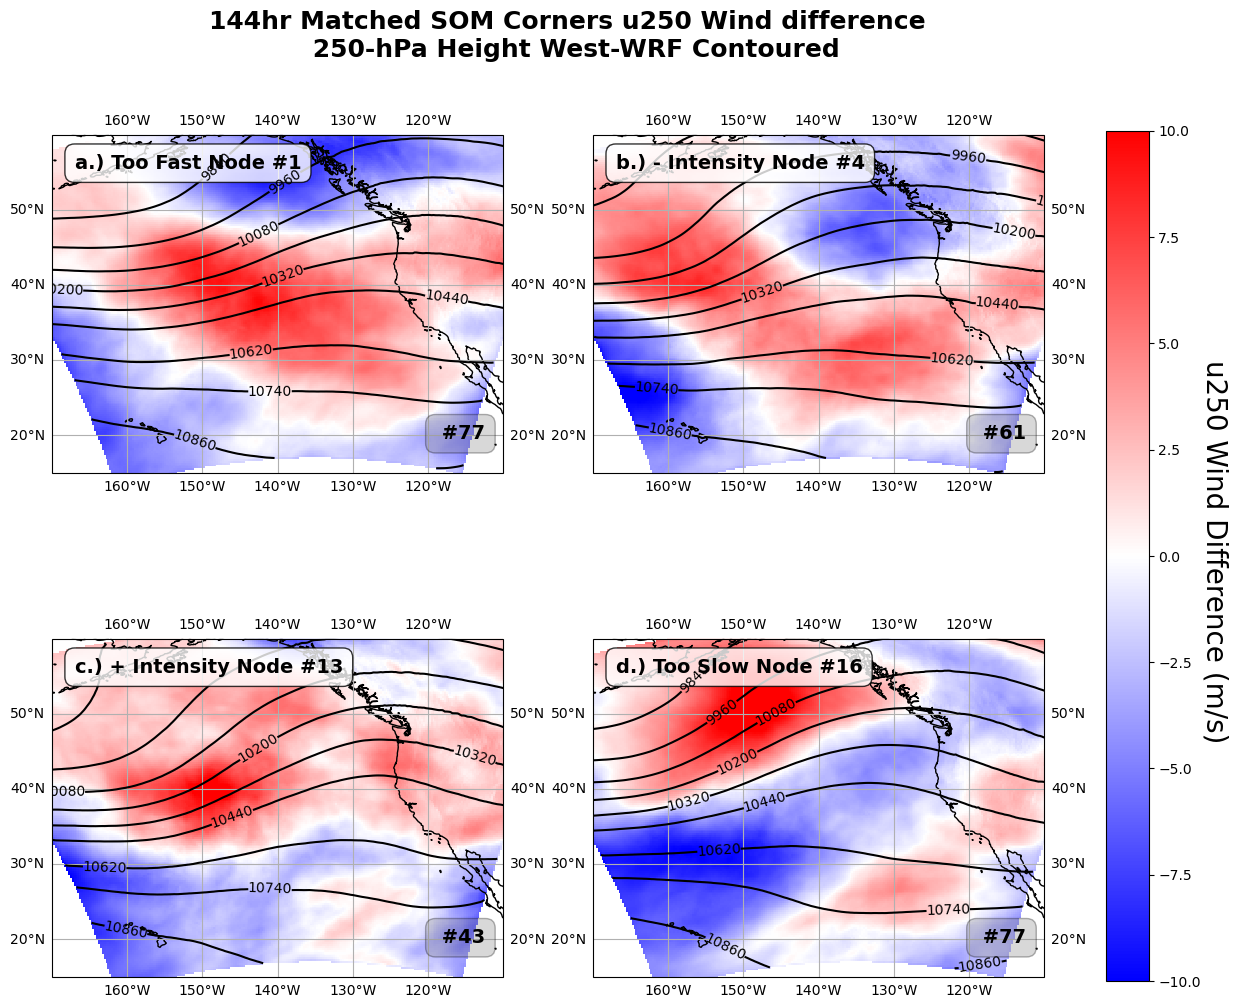

In [143]:
fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12), subplot_kw={'projection': ccrs.PlateCarree()})
#Ht_levels=[5280,5340,5400,5460,5520,5580,5640,5700,5760,5820,5880,6040]
Ht250_levels=[9840,9960,10080,10200,10320,10440,10620,10740,10860,10980,11100]
label_list = ['a.) Too Fast Node #1', 'b.) - Intensity Node #4', 'c.) + Intensity Node #13', 'd.) Too Slow Node #16']
props2 = dict(boxstyle='round', facecolor='gray', alpha=.9)
label=geo_axs[0, 0].pcolormesh(wind_diff['longitude'],wind_diff['latitude'],wind_diff['u'][np.array(winmap[som_keys[0]])].mean(dim='time'), cmap='bwr',vmin=-10,vmax=10)
geo_axs[0, 0].gridlines(draw_labels=True)
geo_axs[0, 0].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[0, 0].coastlines()
geo_axs[0, 0].text(0.05, 0.9, label_list[0], transform=geo_axs[0, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5',alpha=0.8))
htctr=geo_axs[0, 0].contour(era_250ht['longitude'],era_250ht['latitude'],wwrf_ht250_xr['u'][np.array(winmap[som_keys[0]])].mean(dim='time'), colors='black',levels=Ht250_levels)
plt.clabel(htctr,fmt='%1.0f',colors='black')
#geo_axs[0,0].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[0]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[0]])],color='mediumaquamarine')



geo_axs[0, 0].text(0.85, 0.1, f" #{int(len(wind_diff['u'][np.array(winmap[som_keys[0]])]))}", transform=geo_axs[0, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))

label=geo_axs[0, 1].pcolormesh(wind_diff['longitude'],wind_diff['latitude'],wind_diff['u'][np.array(winmap[som_keys[3]])].mean(dim='time'), cmap='bwr',vmin=-10,vmax=10)
geo_axs[0, 1].gridlines(draw_labels=True)
geo_axs[0, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[0, 1].coastlines()
geo_axs[0, 1].text(0.05, 0.9, label_list[1], transform=geo_axs[0, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5',alpha=0.8))
geo_axs[0, 1].text(0.85, 0.1, f" #{int(len(wind_diff['u'][np.array(winmap[som_keys[3]])]))}", transform=geo_axs[0, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))
htctr1=geo_axs[0, 1].contour(era_250ht['longitude'],era_250ht['latitude'],wwrf_ht250_xr['u'][np.array(winmap[som_keys[3]])].mean(dim='time'), colors='black',levels=Ht250_levels)
plt.clabel(htctr1,fmt='%1.0f',colors='black')
#geo_axs[0,1].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[3]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[3]])],color='mediumaquamarine')

label=geo_axs[1, 0].pcolormesh(wind_diff['longitude'],wind_diff['latitude'],wind_diff['u'][np.array(winmap[som_keys[12]])].mean(dim='time'), cmap='bwr',vmin=-10,vmax=10)
geo_axs[1, 0].gridlines(draw_labels=True)
geo_axs[1, 0].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[1, 0].coastlines()
geo_axs[1, 0].text(0.05, 0.9, label_list[2], transform=geo_axs[1, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5',alpha=0.8))
geo_axs[1, 0].text(0.85, 0.1, f" #{int(len(wind_diff['u'][np.array(winmap[som_keys[12]])]))}", transform=geo_axs[1, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray',alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))
htctr2=geo_axs[1, 0].contour(era_250ht['longitude'],era_250ht['latitude'],wwrf_ht250_xr['u'][np.array(winmap[som_keys[12]])].mean(dim='time'), colors='black',levels=Ht250_levels)
plt.clabel(htctr2,fmt='%1.0f',colors='black')
#geo_axs[1,0].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[12]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[12]])],color='mediumaquamarine')

label=geo_axs[1, 1].pcolormesh(wind_diff['longitude'],wind_diff['latitude'],wind_diff['u'][np.array(winmap[som_keys[15]])].mean(dim='time'), cmap='bwr',vmin=-10,vmax=10)

geo_axs[1, 1].gridlines(draw_labels=True)
geo_axs[1, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[1, 1].coastlines()
geo_axs[1, 1].text(0.05, 0.9, label_list[3], transform=geo_axs[1, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5',alpha=0.8))
geo_axs[1, 1].text(0.85, 0.1, f" #{int(len(wind_diff['u'][np.array(winmap[som_keys[15]])]))}", transform=geo_axs[1, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))
htctr3=geo_axs[1, 1].contour(era_250ht['longitude'],era_250ht['latitude'],wwrf_ht250_xr['u'][np.array(winmap[som_keys[15]])].mean(dim='time'), colors='black',levels=Ht250_levels)
plt.clabel(htctr3,fmt='%1.0f',colors='black')
#geo_axs[1,1].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[15]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[15]])],color='mediumaquamarine')
# fig.suptitle(
#     "144hr Corner 258 (out of 849) 500-hPa Height Anomalies",
#     fontsize=18, y=.90, x=0.45, fontweight='bold'
# )
fig.suptitle(
    "144hr Matched SOM Corners u250 Wind difference \n 250-hPa Height West-WRF Contoured",
    fontsize=18, y=.95, x=0.45, fontweight='bold'
)

cbar = fig.colorbar(label, ax=fig.get_axes(),shrink=0.92)
cbar.ax.set_ylabel('u250 Wind Difference (m/s) ', rotation=270, fontsize=20,labelpad=20
          )
#plt.savefig('144htanom_jan2024_corner.png',bbox_inches='tight',pad_inches = 0)
#plt.savefig('144Allnodeswind_ht_july22024.png',bbox_inches='tight',pad_inches = 0)
plt.savefig('correctedWWRF250ht_144CORNERnodeswind_aug5_2024.png',bbox_inches='tight',pad_inches = 0)
plt.show()

In [121]:
ht250_diff=wwrf_ht250_xr['u']-era_250ht

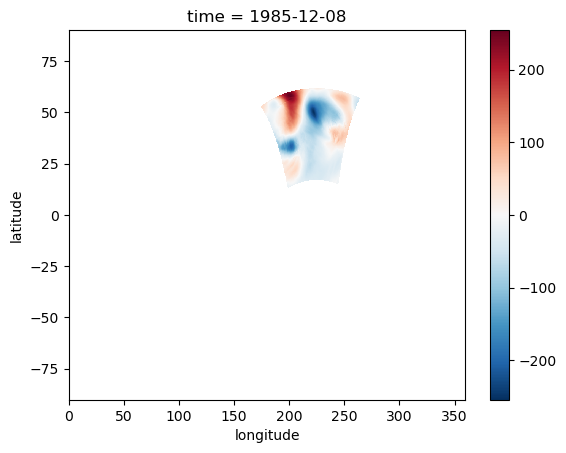

In [123]:
ht250_diff.isel(time=0).plot()

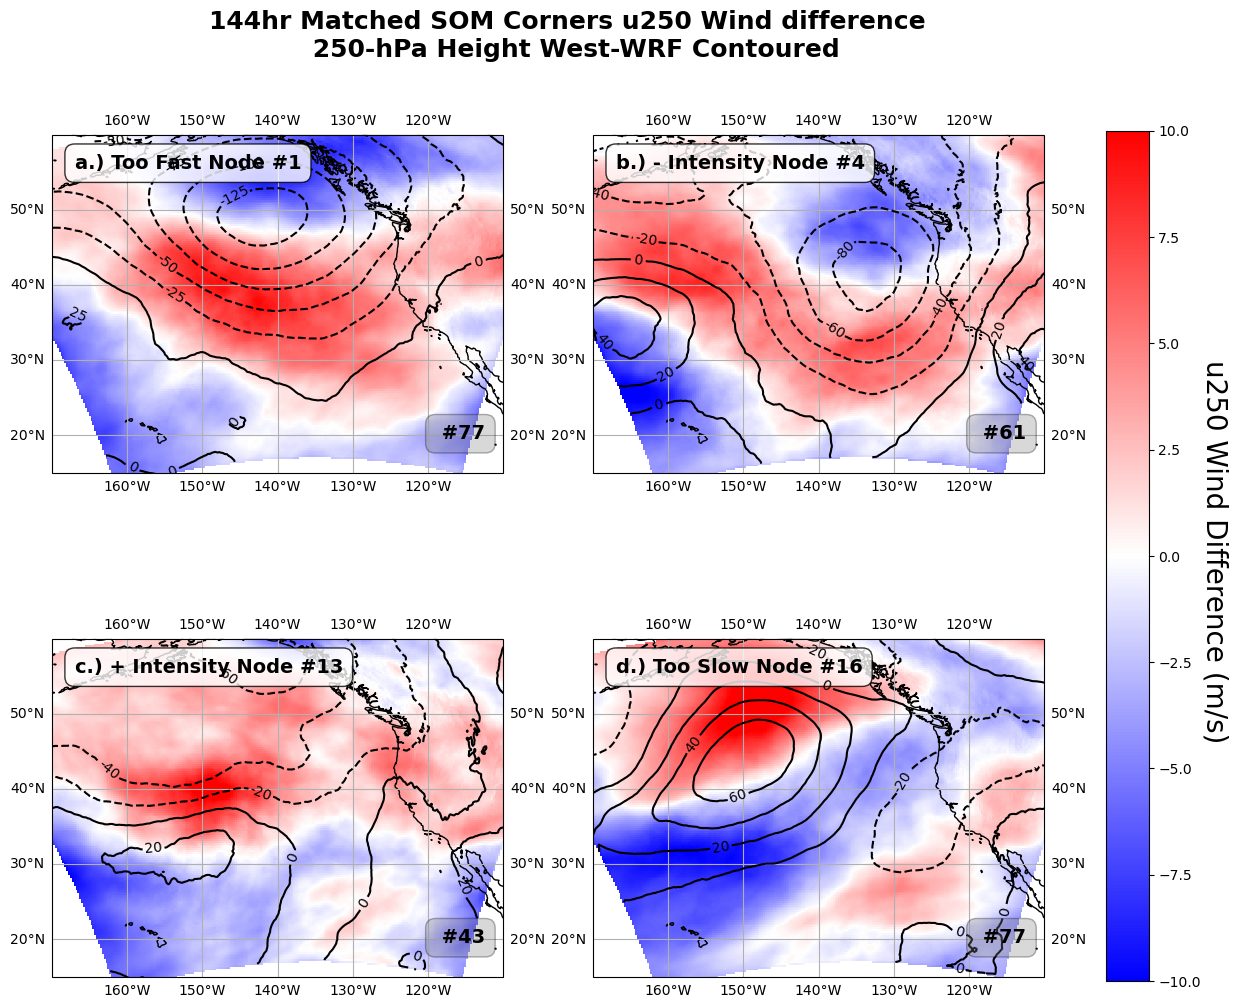

In [125]:
fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12), subplot_kw={'projection': ccrs.PlateCarree()})
#Ht_levels=[5280,5340,5400,5460,5520,5580,5640,5700,5760,5820,5880,6040]
Ht_levels=[10500,10560,10620,10680,10740,10800,10860,10920,10980,11040,11100]
label_list = ['a.) Too Fast Node #1', 'b.) - Intensity Node #4', 'c.) + Intensity Node #13', 'd.) Too Slow Node #16']
props2 = dict(boxstyle='round', facecolor='gray', alpha=.9)
label=geo_axs[0, 0].pcolormesh(wind_diff['longitude'],wind_diff['latitude'],wind_diff['u'][np.array(winmap[som_keys[0]])].mean(dim='time'), cmap='bwr',vmin=-10,vmax=10)
geo_axs[0, 0].gridlines(draw_labels=True)
geo_axs[0, 0].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[0, 0].coastlines()
geo_axs[0, 0].text(0.05, 0.9, label_list[0], transform=geo_axs[0, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5',alpha=0.8))
htctr=geo_axs[0, 0].contour(era_250ht['longitude'],era_250ht['latitude'],ht250_diff[np.array(winmap[som_keys[0]])].mean(dim='time'), colors='black')
plt.clabel(htctr,fmt='%1.0f',colors='black')
#geo_axs[0,0].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[0]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[0]])],color='mediumaquamarine')



geo_axs[0, 0].text(0.85, 0.1, f" #{int(len(wind_diff['u'][np.array(winmap[som_keys[0]])]))}", transform=geo_axs[0, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))

label=geo_axs[0, 1].pcolormesh(wind_diff['longitude'],wind_diff['latitude'],wind_diff['u'][np.array(winmap[som_keys[3]])].mean(dim='time'), cmap='bwr',vmin=-10,vmax=10)
geo_axs[0, 1].gridlines(draw_labels=True)
geo_axs[0, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[0, 1].coastlines()
geo_axs[0, 1].text(0.05, 0.9, label_list[1], transform=geo_axs[0, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5',alpha=0.8))
geo_axs[0, 1].text(0.85, 0.1, f" #{int(len(wind_diff['u'][np.array(winmap[som_keys[3]])]))}", transform=geo_axs[0, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))
htctr1=geo_axs[0, 1].contour(era_250ht['longitude'],era_250ht['latitude'],ht250_diff[np.array(winmap[som_keys[3]])].mean(dim='time'), colors='black')
plt.clabel(htctr1,fmt='%1.0f',colors='black')
#geo_axs[0,1].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[3]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[3]])],color='mediumaquamarine')

label=geo_axs[1, 0].pcolormesh(wind_diff['longitude'],wind_diff['latitude'],wind_diff['u'][np.array(winmap[som_keys[12]])].mean(dim='time'), cmap='bwr',vmin=-10,vmax=10)
geo_axs[1, 0].gridlines(draw_labels=True)
geo_axs[1, 0].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[1, 0].coastlines()
geo_axs[1, 0].text(0.05, 0.9, label_list[2], transform=geo_axs[1, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5',alpha=0.8))
geo_axs[1, 0].text(0.85, 0.1, f" #{int(len(wind_diff['u'][np.array(winmap[som_keys[12]])]))}", transform=geo_axs[1, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray',alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))
htctr2=geo_axs[1, 0].contour(era_250ht['longitude'],era_250ht['latitude'],ht250_diff[np.array(winmap[som_keys[12]])].mean(dim='time'), colors='black')
plt.clabel(htctr2,fmt='%1.0f',colors='black')
#geo_axs[1,0].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[12]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[12]])],color='mediumaquamarine')

label=geo_axs[1, 1].pcolormesh(wind_diff['longitude'],wind_diff['latitude'],wind_diff['u'][np.array(winmap[som_keys[15]])].mean(dim='time'), cmap='bwr',vmin=-10,vmax=10)

geo_axs[1, 1].gridlines(draw_labels=True)
geo_axs[1, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[1, 1].coastlines()
geo_axs[1, 1].text(0.05, 0.9, label_list[3], transform=geo_axs[1, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5',alpha=0.8))
geo_axs[1, 1].text(0.85, 0.1, f" #{int(len(wind_diff['u'][np.array(winmap[som_keys[15]])]))}", transform=geo_axs[1, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))
htctr3=geo_axs[1, 1].contour(era_250ht['longitude'],era_250ht['latitude'],ht250_diff[np.array(winmap[som_keys[15]])].mean(dim='time'), colors='black')
plt.clabel(htctr3,fmt='%1.0f',colors='black')
#geo_axs[1,1].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[15]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[15]])],color='mediumaquamarine')
# fig.suptitle(
#     "144hr Corner 258 (out of 849) 500-hPa Height Anomalies",
#     fontsize=18, y=.90, x=0.45, fontweight='bold'
# )
fig.suptitle(
    "144hr Matched SOM Corners u250 Wind difference \n 250-hPa Height Difference Contoured",
    fontsize=18, y=.95, x=0.45, fontweight='bold'
)

cbar = fig.colorbar(label, ax=fig.get_axes(),shrink=0.92)
cbar.ax.set_ylabel('u250 Wind Difference (m/s) ', rotation=270, fontsize=20,labelpad=20
          )
#plt.savefig('144htanom_jan2024_corner.png',bbox_inches='tight',pad_inches = 0)
#plt.savefig('144Allnodeswind_ht_july22024.png',bbox_inches='tight',pad_inches = 0)
plt.savefig('corrected250htDIFF_144CORNERnodeswind_aug5_2024.png',bbox_inches='tight',pad_inches = 0)
plt.show()

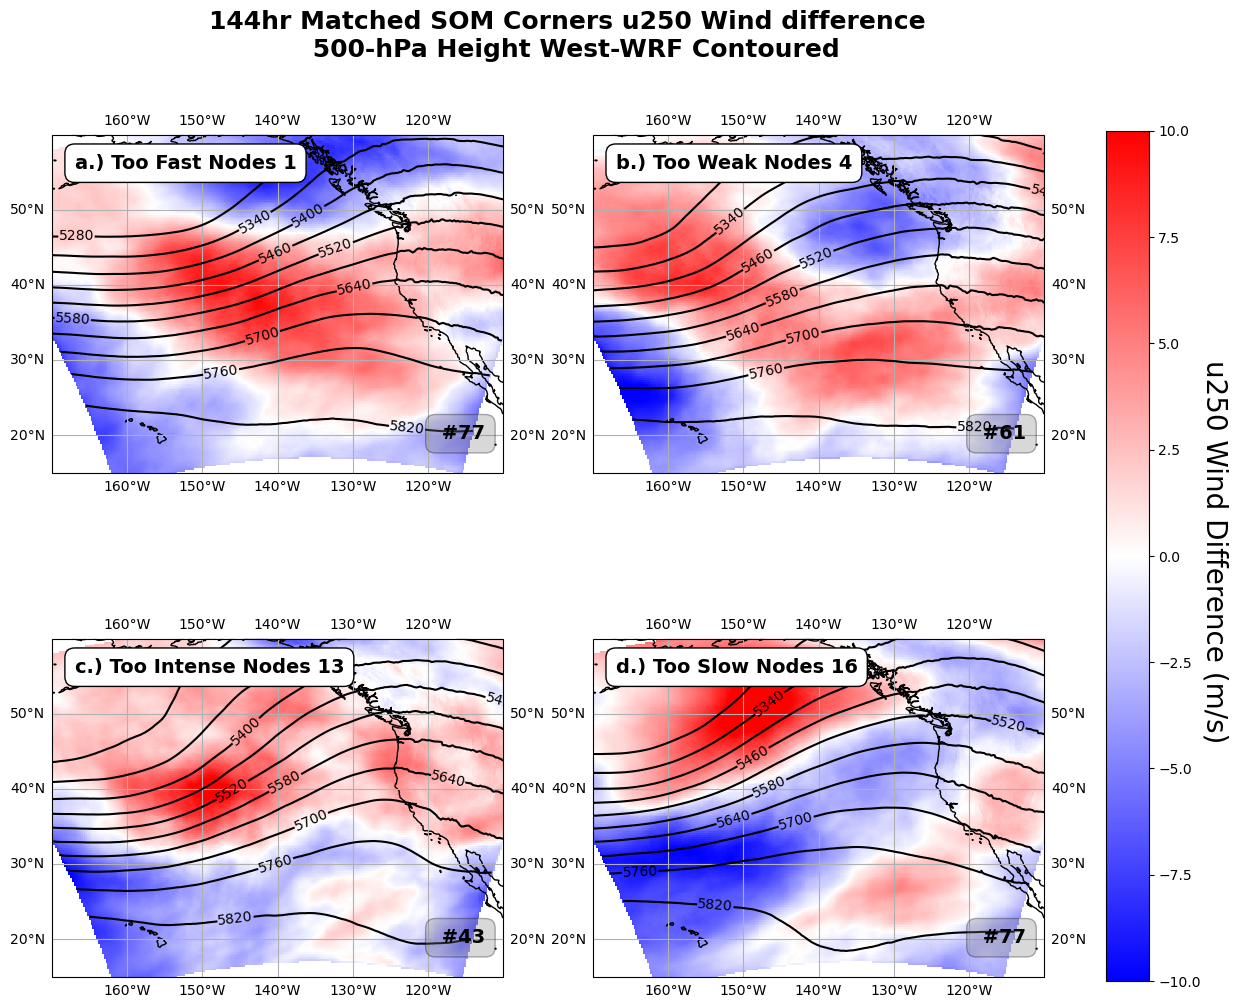

In [164]:
fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12), subplot_kw={'projection': ccrs.PlateCarree()})
Ht_levels=[5280,5340,5400,5460,5520,5580,5640,5700,5760,5820,5880,6040]
laebel_list = ['a.) Too Fast Nodes 1', 'b.) Too Weak Nodes 4', 'c.) Too Intense Nodes 13', 'd.) Too Slow Nodes 16']
props2 = dict(boxstyle='round', facecolor='gray', alpha=.9)
label=geo_axs[0, 0].pcolormesh(wind_diff['longitude'],wind_diff['latitude'],wind_diff[np.array(winmap[som_keys[0]])].mean(dim='time'), cmap='bwr',vmin=-10,vmax=10)
geo_axs[0, 0].gridlines(draw_labels=True)
geo_axs[0, 0].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[0, 0].coastlines()
geo_axs[0, 0].text(0.05, 0.9, label_list[0], transform=geo_axs[0, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
htctr=geo_axs[0, 0].contour(ht_lines['lon'],ht_lines['lat'],ht_lines['variable'][np.array(winmap[som_keys[0]])].mean(dim='time'), colors='black',levels=Ht_levels)
plt.clabel(htctr,fmt='%1.0f',colors='black')
#geo_axs[0,0].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[0]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[0]])],color='mediumaquamarine')



geo_axs[0, 0].text(0.85, 0.1, f" #{int(len(wind_diff[np.array(winmap[som_keys[0]])]))}", transform=geo_axs[0, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))

label=geo_axs[0, 1].pcolormesh(wind_diff['longitude'],wind_diff['latitude'],wind_diff[np.array(winmap[som_keys[3]])].mean(dim='time'), cmap='bwr',vmin=-10,vmax=10)
geo_axs[0, 1].gridlines(draw_labels=True)
geo_axs[0, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[0, 1].coastlines()
geo_axs[0, 1].text(0.05, 0.9, label_list[1], transform=geo_axs[0, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[0, 1].text(0.85, 0.1, f" #{int(len(wind_diff[np.array(winmap[som_keys[3]])]))}", transform=geo_axs[0, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))
htctr1=geo_axs[0, 1].contour(ht_lines['lon'],ht_lines['lat'],ht_lines['variable'][np.array(winmap[som_keys[3]])].mean(dim='time'), colors='black',levels=Ht_levels)
plt.clabel(htctr1,fmt='%1.0f',colors='black')
#geo_axs[0,1].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[3]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[3]])],color='mediumaquamarine')

label=geo_axs[1, 0].pcolormesh(wind_diff['longitude'],wind_diff['latitude'],wind_diff[np.array(winmap[som_keys[12]])].mean(dim='time'), cmap='bwr',vmin=-10,vmax=10)
geo_axs[1, 0].gridlines(draw_labels=True)
geo_axs[1, 0].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[1, 0].coastlines()
geo_axs[1, 0].text(0.05, 0.9, label_list[2], transform=geo_axs[1, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[1, 0].text(0.85, 0.1, f" #{int(len(wind_diff[np.array(winmap[som_keys[12]])]))}", transform=geo_axs[1, 0].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray',alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))
htctr2=geo_axs[1, 0].contour(ht_lines['lon'],ht_lines['lat'],ht_lines['variable'][np.array(winmap[som_keys[12]])].mean(dim='time'), colors='black',levels=Ht_levels)
plt.clabel(htctr2,fmt='%1.0f',colors='black')
#geo_axs[1,0].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[12]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[12]])],color='mediumaquamarine')

label=geo_axs[1, 1].pcolormesh(wind_diff['longitude'],wind_diff['latitude'],wind_diff[np.array(winmap[som_keys[15]])].mean(dim='time'), cmap='bwr',vmin=-10,vmax=10)

geo_axs[1, 1].gridlines(draw_labels=True)
geo_axs[1, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
geo_axs[1, 1].coastlines()
geo_axs[1, 1].text(0.05, 0.9, label_list[3], transform=geo_axs[1, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
geo_axs[1, 1].text(0.85, 0.1, f" #{int(len(wind_diff[np.array(winmap[som_keys[15]])]))}", transform=geo_axs[1, 1].transAxes, fontsize=14, fontweight='bold', color='black',
        bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))
htctr3=geo_axs[1, 1].contour(ht_lines['lon'],ht_lines['lat'],ht_lines['variable'][np.array(winmap[som_keys[15]])].mean(dim='time'), colors='black',levels=Ht_levels)
plt.clabel(htctr3,fmt='%1.0f',colors='black')
#geo_axs[1,1].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[15]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[15]])],color='mediumaquamarine')
# fig.suptitle(
#     "144hr Corner 258 (out of 849) 500-hPa Height Anomalies",
#     fontsize=18, y=.90, x=0.45, fontweight='bold'
# )
fig.suptitle(
    "144hr Matched SOM Corners u250 Wind difference \n 500-hPa Height West-WRF Contoured",
    fontsize=18, y=.95, x=0.45, fontweight='bold'
)

cbar = fig.colorbar(label, ax=fig.get_axes(),shrink=0.92)
cbar.ax.set_ylabel('u250 Wind Difference (m/s) ', rotation=270, fontsize=20,labelpad=20
          )
#plt.savefig('144htanom_jan2024_corner.png',bbox_inches='tight',pad_inches = 0)
#plt.savefig('144Allnodeswind_ht_july22024.png',bbox_inches='tight',pad_inches = 0)
plt.savefig('corrected500ht_144CORNERnodeswind_aug2_2024.png',bbox_inches='tight',pad_inches = 0)
plt.show()

In [151]:
# fig, geo_axs = plt.subplots(2, 2, figsize=(16, 12), subplot_kw={'projection': ccrs.PlateCarree()})
# label_list = ['a.) Too Fast Nodes 1', 'b.) Too Weak Nodes 4', 'c.) Too Intense Nodes 13', 'd.) Too Slow Nodes 16']
# props2 = dict(boxstyle='round', facecolor='gray', alpha=.9)
# label=geo_axs[0, 0].pcolormesh(wind_diff_0['longitude'],wind_diff_0['latitude'],wind_diff_0[np.array(winmap[som_keys[0]])].mean(dim='time'), cmap='bwr')
# geo_axs[0, 0].gridlines(draw_labels=True)
# geo_axs[0, 0].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
# geo_axs[0, 0].coastlines()
# geo_axs[0, 0].text(0.05, 0.9, label_list[0], transform=geo_axs[0, 0].transAxes, fontsize=14, fontweight='bold', color='black',
#         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
# # htctr=geo_axs[0, 0].contour(ht_diff_new['lon'],ht_diff_new['lat'],ht_diff_new['variable'][np.array(winmap[som_keys[0]])].mean(dim='time'), colors='black')
# # plt.clabel(htctr,fmt='%1.0f',colors='black')
# #geo_axs[0,0].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[0]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[0]])],color='mediumaquamarine')



# geo_axs[0, 0].text(0.85, 0.1, f" #{int(len(wind_diff[np.array(winmap[som_keys[0]])]))}", transform=geo_axs[0, 0].transAxes, fontsize=14, fontweight='bold', color='black',
#         bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))

# label=geo_axs[0, 1].pcolormesh(wind_diff_0['longitude'],wind_diff_0['latitude'],wind_diff_0[np.array(winmap[som_keys[3]])].mean(dim='time'), cmap='bwr')
# geo_axs[0, 1].gridlines(draw_labels=True)
# geo_axs[0, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
# geo_axs[0, 1].coastlines()
# geo_axs[0, 1].text(0.05, 0.9, label_list[1], transform=geo_axs[0, 1].transAxes, fontsize=14, fontweight='bold', color='black',
#         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
# geo_axs[0, 1].text(0.85, 0.1, f" #{int(len(wind_diff[np.array(winmap[som_keys[3]])]))}", transform=geo_axs[0, 1].transAxes, fontsize=14, fontweight='bold', color='black',
#         bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))
# # htctr1=geo_axs[0, 1].contour(ht_diff_new['lon'],ht_diff_new['lat'],ht_diff_new['variable'][np.array(winmap[som_keys[3]])].mean(dim='time'), colors='black')
# # plt.clabel(htctr1,fmt='%1.0f',colors='black')
# #geo_axs[0,1].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[3]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[3]])],color='mediumaquamarine')

# label=geo_axs[1, 0].pcolormesh(wind_diff_0['longitude'],wind_diff_0['latitude'],wind_diff_0[np.array(winmap[som_keys[12]])].mean(dim='time'), cmap='bwr')
# geo_axs[1, 0].gridlines(draw_labels=True)
# geo_axs[1, 0].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
# geo_axs[1, 0].coastlines()
# geo_axs[1, 0].text(0.05, 0.9, label_list[2], transform=geo_axs[1, 0].transAxes, fontsize=14, fontweight='bold', color='black',
#         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
# geo_axs[1, 0].text(0.85, 0.1, f" #{int(len(wind_diff[np.array(winmap[som_keys[12]])]))}", transform=geo_axs[1, 0].transAxes, fontsize=14, fontweight='bold', color='black',
#         bbox=dict(facecolor='gray',alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))
# # htctr2=geo_axs[1, 0].contour(ht_diff_new['lon'],ht_diff_new['lat'],ht_diff_new['variable'][np.array(winmap[som_keys[12]])].mean(dim='time'), colors='black')
# # plt.clabel(htctr2,fmt='%1.0f',colors='black')
# #geo_axs[1,0].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[12]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[12]])],color='mediumaquamarine')

# label=geo_axs[1, 1].pcolormesh(wind_diff_0['longitude'],wind_diff_0['latitude'],wind_diff_0[np.array(winmap[som_keys[15]])].mean(dim='time'), cmap='bwr')

# geo_axs[1, 1].gridlines(draw_labels=True)
# geo_axs[1, 1].set_extent([-170, -110, 15, 60], crs=ccrs.PlateCarree())
# geo_axs[1, 1].coastlines()
# geo_axs[1, 1].text(0.05, 0.9, label_list[3], transform=geo_axs[1, 1].transAxes, fontsize=14, fontweight='bold', color='black',
#         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
# geo_axs[1, 1].text(0.85, 0.1, f" #{int(len(wind_diff[np.array(winmap[som_keys[15]])]))}", transform=geo_axs[1, 1].transAxes, fontsize=14, fontweight='bold', color='black',
#         bbox=dict(facecolor='gray', alpha= .3, edgecolor='black', boxstyle='round,pad=0.5'))
# # htctr3=geo_axs[1, 1].contour(ht_diff_new['lon'],ht_diff_new['lat'],ht_diff_new['variable'][np.array(winmap[som_keys[15]])].mean(dim='time'), colors='black')
# # plt.clabel(htctr3,fmt='%1.0f',colors='black')
# #geo_axs[1,1].scatter(centroid_total_grid['centroid_x'][np.array(winmap[som_keys[15]])],centroid_total_grid['centroid_y'][np.array(winmap[som_keys[15]])],color='mediumaquamarine')
# # fig.suptitle(
# #     "144hr Corner 258 (out of 849) 500-hPa Height Anomalies",
# #     fontsize=18, y=.90, x=0.45, fontweight='bold'
# # )
# fig.suptitle(
#     "144hr Matched SOM Corners u250 Wind difference \n 500-hPa West-WRF - ERA5 Difference Contoured",
#     fontsize=18, y=.95, x=0.45, fontweight='bold'
# )

# cbar = fig.colorbar(label, ax=fig.get_axes(),shrink=0.92)
# cbar.ax.set_ylabel('u250 Wind Difference (m/s) ', rotation=270, fontsize=20,labelpad=20
#           )
# #plt.savefig('144htanom_jan2024_corner.png',bbox_inches='tight',pad_inches = 0)
# #plt.savefig('144Allnodeswind_ht_july22024.png',bbox_inches='tight',pad_inches = 0)
# plt.savefig('144250winds_removednans.png',bbox_inches='tight',pad_inches = 0)
# plt.show()

In [ ]:
wind_speed_kt
wind_speed_m_s = wind_speed_kt * 0.514444

# Assign the converted wind speed back to the dataset or save it as a new variable
ds['wind_speed_variable_m_s'] = wind_speed_m_s

In [ ]:
wwrf_wind_ms=wwrf_wind_xr *0.514444

In [ ]:
wwrf_wind_ms['u'].isel(time=0).plot()